In [1]:
# uncomment the last two cell to clone the data and enable the GPU
#! git clone https://github.com/ParsProgrammer/ERS.git

In [2]:
#cd ERS

# **Packages**

In [3]:
%pip install tensorflow-gpu==2.9
%pip install tensorflow-text

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import tensorflow as tf
import tensorflow_text as tf_text

In [5]:
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import gzip
import gc
import numpy as np
from tensorflow import keras
from sklearn.model_selection import KFold
import datetime 
import os
import matplotlib.pyplot as plt


In [7]:
%pip install gensim==4.2
%pip install nltk

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [8]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import gensim.downloader as api
from nltk.tokenize import sent_tokenize, word_tokenize


In [9]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/mobin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
else :
  print("No GPU available")

2022-12-18 10:03:09.000020: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


1 Physical GPUs, 1 Logical GPUs


2022-12-18 10:03:09.015715: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 10:03:09.015886: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-18 10:03:09.016769: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-18 10:03:09.019163: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [11]:
%pip install tensorboard
%pip install -U tensorboard_plugin_profile

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# **Data Extraction**

In [12]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    name=b'"verified": \"true\",'
    l=l.replace(b'"verified": true,',bytes(name))
    name1=b'"verified": \"false\",'
    l=l.replace(b'"verified": false,',bytes(name))
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('reviews_Grocery_and_Gourmet_Food_5.json.gz')

# dataset link
# Grocery and Gourmet Food
# https://jmcauley.ucsd.edu/data/amazon/

Dataset Schema

In [13]:
df.rename(columns={"reviewerID": "userID", "asin": "itemID","overall":"rating"},inplace=True)
df=df[['userID','itemID','reviewText','rating']]
df

,userID,itemID,reviewText,rating
0,A1VEELTKS8NLZB,616719923X,Just another flavor of Kit Kat but the taste i...,4.0
1,A14R9XMZVJ6INB,616719923X,I bought this on impulse and it comes from Jap...,3.0
2,A27IQHDZFQFNGG,616719923X,Really good. Great gift for any fan of green t...,4.0
3,A31QY5TASILE89,616719923X,"I had never had it before, was curious to see ...",5.0
4,A2LWK003FFMCI5,616719923X,I've been looking forward to trying these afte...,4.0
...,...,...,...,...
151249,A2L6QS8SVHT9RG,B00KCJRVO2,Delicious gluten-free oatmeal: we tried both t...,4.0
151250,AFJFXN42RZ3G2,B00KCJRVO2,With the many selections of instant oatmeal ce...,4.0
151251,ASEBX8TBYWQWA,B00KCJRVO2,"While I usually review CDs and DVDs, as well a...",5.0
151252,ANKQGTXHREOI5,B00KCJRVO2,My son and I enjoyed these oatmeal packets. H...,4.0


In [14]:
df.sample(10)

,userID,itemID,reviewText,rating
31052,A31LKJUARHR0Y,B000PGHLNS,I remember these cookies from the early 1980s ...,5.0
145051,A3Q1J68QY1MZQ9,B00DBSG2WI,These are disgusting!!! Are we reviewing the s...,1.0
67790,A36WGHR8TO5DKT,B0029JDUO8,"First, let me just say that the Xyla mint prod...",4.0
60239,A27NTHPTRXB766,B001M0AL8I,Never liked oatmeal until fruit entered the pi...,5.0
122962,A2HTPS0JV3Q8ZD,B006MONQMC,"While I like the MIO additives, I am always he...",5.0
106568,A1ITRGMT80D5TK,B004U43ZO0,These cookies are okay but they certainly aren...,3.0
53091,A2V0I904FH7ABY,B001EQ55ZO,The cashew are well roasted giving it a nice f...,3.0
143427,A2OBDNQ5ZYU1L8,B00CQ92YPW,I don't use a lot of salt in cooking or direct...,5.0
87341,ABKNRVFFLEA3M,B003XDH6M6,This is really great tasting licorice. The po...,5.0
41182,A4EWLZLUCY5QR,B0016COPU2,now THIS is a real nice meal when i just can't...,5.0


# **Data Analysis**

**User Data**

determining all unique users with their reviews and ratings

In [15]:
user_df=df[['userID','reviewText','rating']].groupby('userID')['rating','reviewText'].apply(lambda x: pd.Series([list(x['reviewText']),list(x['rating'])],index=['reviewText', 'rating'])).reset_index()
user_df

/home/mobin/anaconda3/envs/colabenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,userID,reviewText,rating
0,A00177463W0XWB16A9O05,[It is a good stand by coffee you can count on...,"[5.0, 5.0, 4.0, 4.0, 5.0, 3.0, 4.0, 5.0, 5.0, ..."
1,A022899328A0QROR32DCT,[awesome texture for even the gluten eating ea...,"[5.0, 1.0, 4.0, 5.0, 5.0, 5.0, 1.0, 2.0, 3.0, ..."
2,A04309042SDSL8YX2HRR7,[I love roasted garlic & sweet bell peppers. Y...,"[5.0, 2.0, 4.0, 4.0, 4.0]"
3,A068255029AHTHDXZURNU,[These bars are especially delicious for cocon...,"[5.0, 5.0, 3.0, 5.0, 3.0, 3.0, 5.0, 5.0, 5.0]"
4,A06944662TFWOKKV4GJKX,[UGH! My stomach has been really killing me l...,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, 4.0]"
...,...,...,...
14676,AZWRZZAMX90VT,"[Very nice. Not spicy, not too salty, lots of ...","[5.0, 5.0, 2.0, 5.0, 5.0, 4.0, 4.0, 3.0, 4.0, ..."
14677,AZXKAH2DE6C8A,[Could not imagine having such a rich tasting ...,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 4.0, ..."
14678,AZXON596A1VXC,[I was a bit skeptical when I bought this prod...,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]"
14679,AZYXC63SS008M,[This is just about the healthiest you can get...,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0]"


**Item Data**

determining all unique items with their reviews and ratings

In [16]:
item_df=df[['itemID','reviewText','rating']].groupby('itemID')['reviewText','rating'].apply(lambda x: pd.Series([list(x['reviewText']),list(x['rating'])],index=['reviewText', 'rating'])).reset_index()
item_df

/home/mobin/anaconda3/envs/colabenv/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


,itemID,reviewText,rating
0,616719923X,[Just another flavor of Kit Kat but the taste ...,"[4.0, 3.0, 4.0, 5.0, 4.0, 4.0, 3.0, 5.0, 5.0, ..."
1,9742356831,[This curry paste makes a delicious curry. I ...,"[5.0, 5.0, 5.0, 4.0, 5.0, 5.0, 5.0, 5.0, 5.0, ..."
2,B00004S1C5,[These dyes create awesome colors for kids cra...,"[5.0, 1.0, 5.0, 5.0, 5.0, 4.0, 4.0]"
3,B0000531B7,[I really enjoy these bars as a quick breakfas...,"[5.0, 5.0, 3.0, 5.0, 5.0, 4.0, 5.0, 5.0, 4.0]"
4,B00005344V,"[Traditional Medicinals' ""Breathe Easy"" is an ...","[5.0, 3.0, 5.0, 5.0, 3.0, 5.0, 5.0]"
...,...,...,...
8708,B00JGPG60I,[We switched to this formula 5 days ago and fo...,"[4.0, 4.0, 4.0, 5.0, 4.0, 3.0, 5.0, 5.0, 2.0, ..."
8709,B00JL6LTMW,[We have enjoyed Larabar's variety of bars for...,"[4.0, 5.0, 5.0, 5.0, 5.0, 4.0, 5.0, 4.0, 5.0, ..."
8710,B00K00H9I6,[This 100% pure Canadian maple syrup is a Grad...,"[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0]"
8711,B00KC0LGI8,[I followed the directions on the box exactly ...,"[2.0, 4.0, 4.0, 4.0, 4.0, 5.0, 2.0, 5.0, 3.0, ..."


In [17]:
# dataset minimization
sample_userID = list( user_df[user_df['reviewText'].apply(lambda x : len(x)> 80 )].sample(50)['userID'])
new_df = df[ df['userID'].isin(sample_userID)]
item_ddf = new_df[['itemID','reviewText','rating']].groupby('itemID')['reviewText','rating'].apply(lambda x: pd.Series([list(x['reviewText']),list(x['rating'])],index=['reviewText', 'rating'])).reset_index()
sample_itemID = list( item_ddf[ item_ddf['reviewText'].apply(lambda x : len(x)>4)]['itemID'] )
df = new_df[new_df['itemID'].isin(sample_itemID)].reset_index(drop= True)
user_df=df[['userID','reviewText','rating']].groupby('userID')['rating','reviewText'].apply(lambda x: pd.Series([list(x['reviewText']),list(x['rating'])],index=['reviewText', 'rating'])).reset_index()
item_df=df[['itemID','reviewText','rating']].groupby('itemID')['reviewText','rating'].apply(lambda x: pd.Series([list(x['reviewText']),list(x['rating'])],index=['reviewText', 'rating'])).reset_index()


/home/mobin/anaconda3/envs/colabenv/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  after removing the cwd from sys.path.
/home/mobin/anaconda3/envs/colabenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  import sys
/home/mobin/anaconda3/envs/colabenv/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [18]:
print("review num : ", df.shape[0] ,"user num : " ,user_df.shape[0],"item num : ",item_df.shape[0] )

review num :  1914 user num :  50 item num :  198


##   Ratings

count    1914.000000
mean        3.964995
std         1.032320
min         1.000000
25%         3.000000
50%         4.000000
75%         5.000000
max         5.000000
Name: rating, dtype: float64

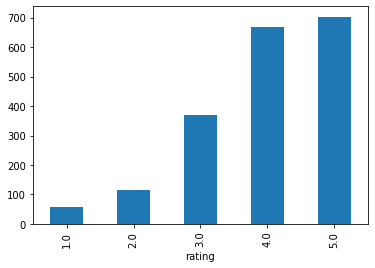

In [19]:
df.groupby('rating').size().plot(kind="bar");
df['rating'].describe()
#histogram of ratings

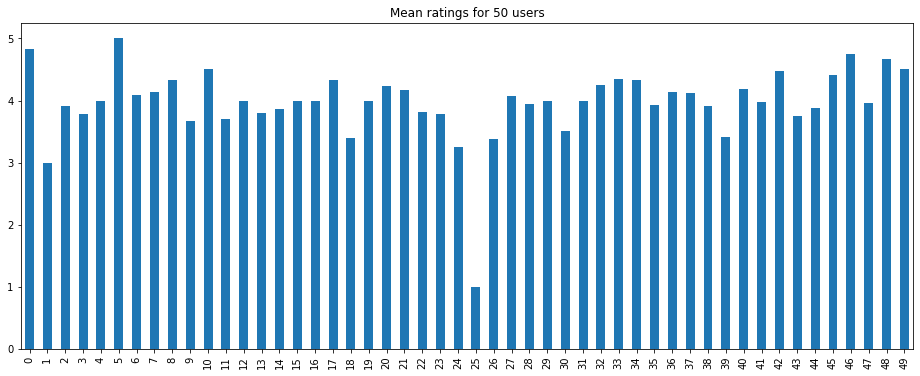

In [20]:
user_means=user_df.rating.apply(lambda x: np.mean(x))
user_means[:50].plot(kind="bar", grid=False, figsize=(16, 6), title="Mean ratings for 50 users");

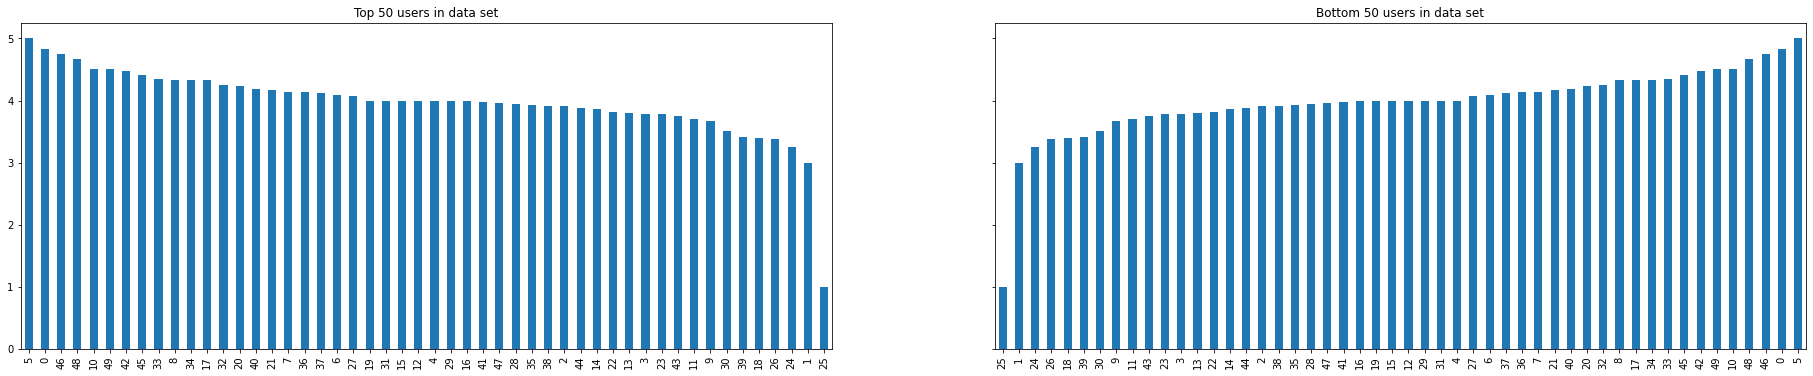

In [21]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(32,6), sharey=True)
user_means.nlargest(50).plot(kind="bar", ax=ax1, title="Top 50 users in data set")
user_means.nsmallest(50).plot(kind="bar", ax=ax2, title="Bottom 50 users in data set");

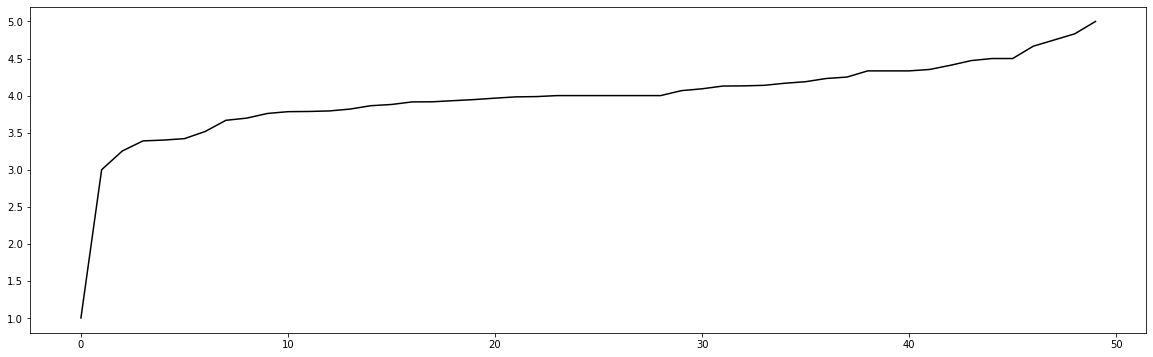

In [22]:
user_means = df.groupby("userID").rating.mean().sort_values()
_, ax = plt.subplots(figsize=(20, 6))
ax.plot(np.arange(len(user_means)), user_means.values, "k-")


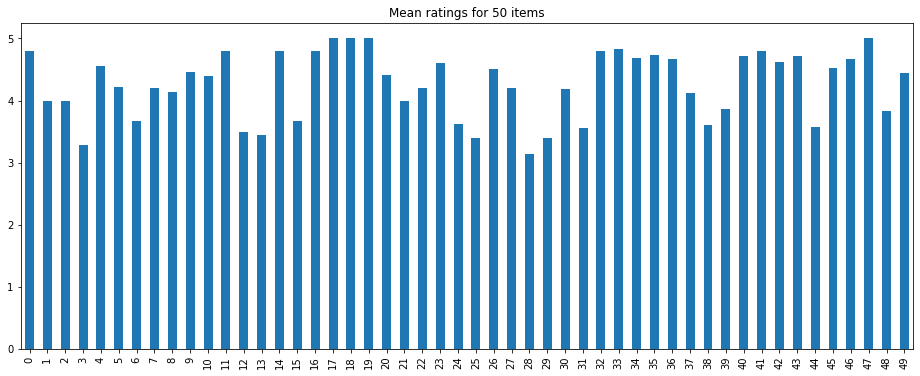

In [23]:
item_means=item_df.rating.apply(lambda x: np.mean(x))
item_means[:50].plot(kind="bar", grid=False, figsize=(16, 6), title="Mean ratings for 50 items");

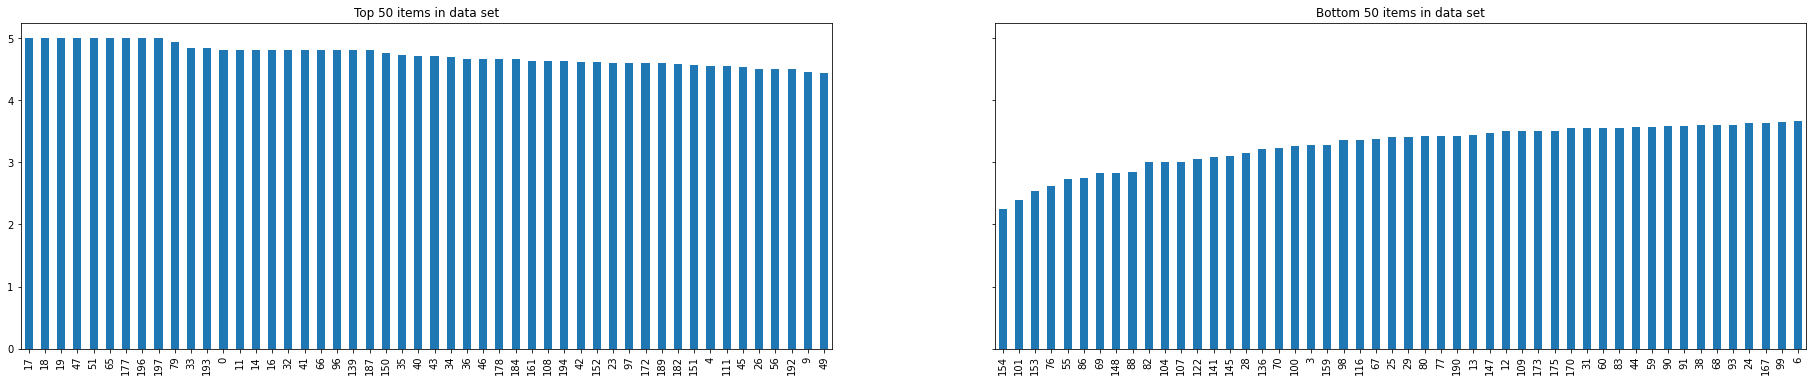

In [24]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(32,6), sharey=True)
item_means.nlargest(50).plot(kind="bar", ax=ax1, title="Top 50 items in data set")
item_means.nsmallest(50).plot(kind="bar", ax=ax2, title="Bottom 50 items in data set");

## Reviews

In [25]:
df['reviewText'].describe()

count                                                  1914
unique                                                 1914
top       Many reviewers have already commented on the f...
freq                                                      1
Name: reviewText, dtype: object

count    1914.000000
mean      744.041797
std       509.664720
min        78.000000
25%       429.000000
50%       613.500000
75%       888.750000
max      8136.000000
Name: reviewText, dtype: float64

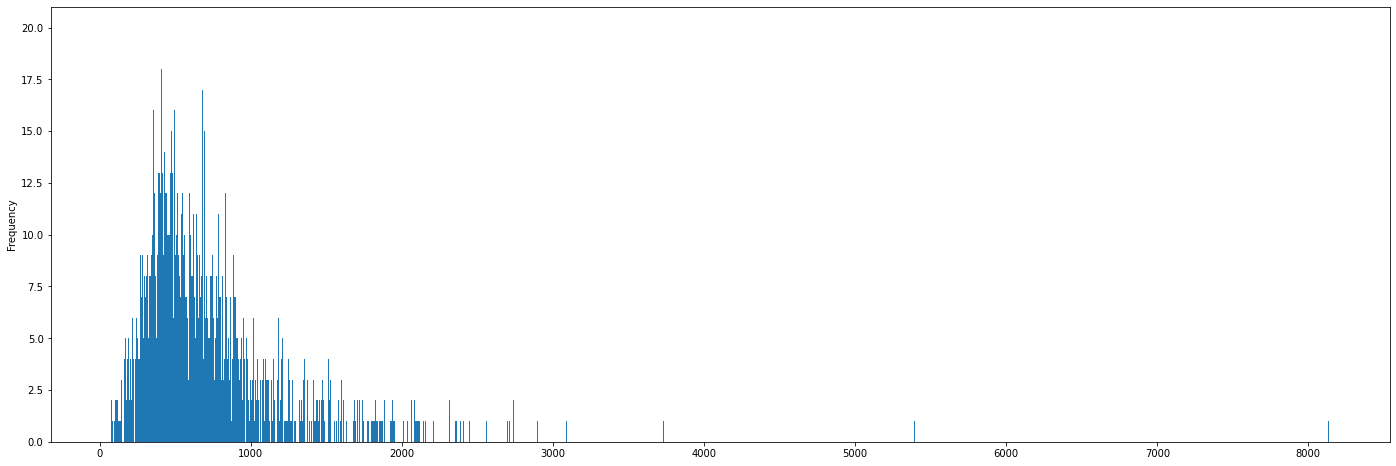

In [26]:
# review length
rv_le=df['reviewText'].apply(lambda x:len(x) )
rv_le.plot(kind='hist',bins=2000,figsize=(24, 8),xlabel="length of reviews")
rv_le.describe()


In [27]:
sum=0
sum2=0
for x in user_df['reviewText']:
  sum+=len(x)
  for y in x:
   sum2 +=len(y)

r_mean=sum/len(user_df['reviewText'])
w_mean=sum2/(r_mean*len(user_df['reviewText']))
print('mean of reviews per user:', r_mean)
print('mean of words per review:', w_mean)
print('mean of words per user:',r_mean * w_mean)
# plot for reviews per user

mean of reviews per user: 38.28
mean of words per review: 744.0417972831766
mean of words per user: 28481.920000000002


In [28]:
a=item_df['reviewText'].apply(len)
a[a>40]

Series([], Name: reviewText, dtype: int64)

count    198.000000
mean       9.666667
std        4.472136
min        5.000000
25%        6.000000
50%        9.000000
75%       13.000000
max       30.000000
Name: reviewText, dtype: float64

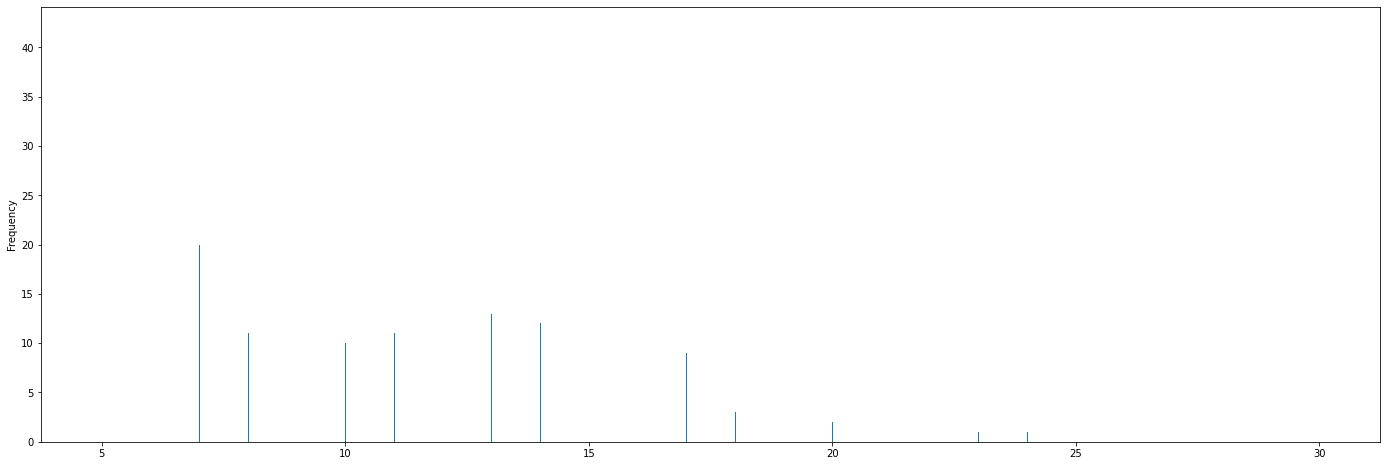

In [29]:
rv_le=item_df['reviewText'].apply(lambda x:len(x) )
rv_le.plot(kind='hist',bins=2000,figsize=(24, 8),xlabel="length of reviews")
rv_le.describe()

count     50.000000
mean      38.280000
std       30.700023
min        1.000000
25%       12.750000
50%       31.000000
75%       61.750000
max      115.000000
Name: reviewText, dtype: float64

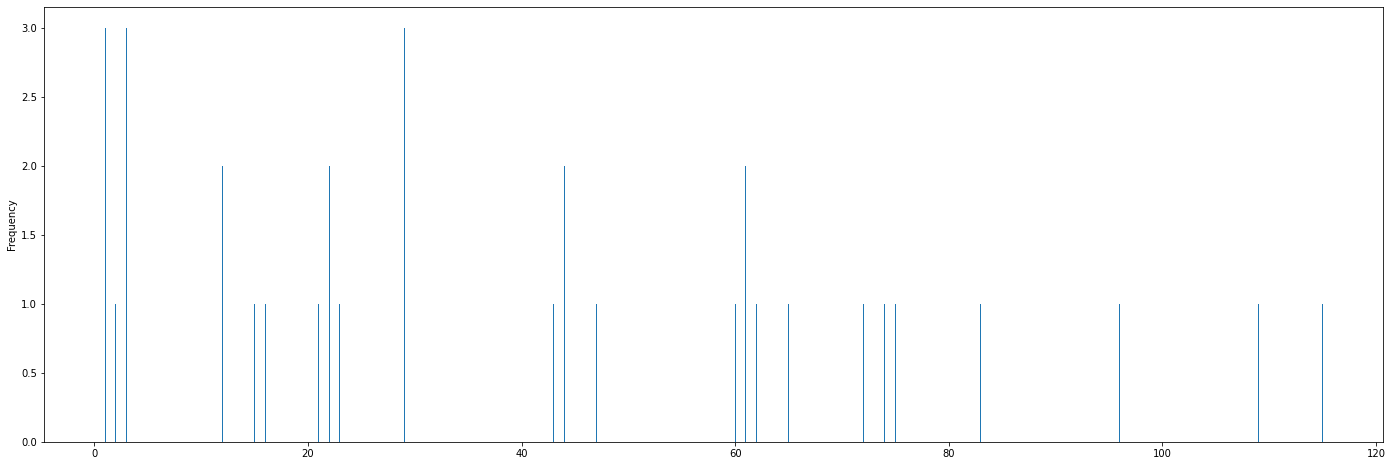

In [30]:
rv_le=user_df['reviewText'].apply(lambda x:len(x) )
rv_le.plot(kind='hist',bins=2000,figsize=(24, 8),xlabel="length of reviews")
rv_le.describe()

In [31]:
sum=0
sum2=0
for x in item_df['reviewText']:
  sum+=len(x)
  for y in x:
   sum2 +=len(y)

r_mean=sum/len(item_df['reviewText'])
w_mean=sum2/(r_mean*len(item_df['reviewText']))
print('mean of reviews per item:', r_mean)
print('mean of words per review:', w_mean)
print('mean of words per item:',r_mean * w_mean)

mean of reviews per item: 9.666666666666666
mean of words per review: 744.0417972831767
mean of words per item: 7192.404040404042


# **Data Splitting**

In [32]:
current_fold=10
kfold = KFold(10)
random_iterator=kfold.split(df)
for i in range(current_fold):
  train_index, test_index = next(random_iterator, None)
  print(train_index,len(train_index))
  train_df, test_df =df.iloc[train_index], df.iloc[test_index]
train_df

[ 192  193  194 ... 1911 1912 1913] 1722
[   0    1    2 ... 1911 1912 1913] 1722
[   0    1    2 ... 1911 1912 1913] 1722
[   0    1    2 ... 1911 1912 1913] 1722
[   0    1    2 ... 1911 1912 1913] 1723
[   0    1    2 ... 1911 1912 1913] 1723
[   0    1    2 ... 1911 1912 1913] 1723
[   0    1    2 ... 1911 1912 1913] 1723
[   0    1    2 ... 1911 1912 1913] 1723
[   0    1    2 ... 1720 1721 1722] 1723


,userID,itemID,reviewText,rating
0,A36WGHR8TO5DKT,B00099XNG0,Many reviewers have already commented on the f...,5.0
1,AKMEY1BSHSDG7,B00099XNG0,Chex Mix Sour Cream & Onion flavor is a good s...,4.0
2,A1X1CEGHTHMBL1,B00099XNG0,"Wow, what a mixture of great tasting things. ...",5.0
3,A1ZH9LWMX5UCFJ,B00099XNG0,I have always been a fan of sweet and salty sn...,5.0
4,A2MNB77YGJ3CN0,B00099XNG0,Excellent snack for those of us who prefer our...,5.0
...,...,...,...,...
1718,A2V92F5R7MLCVI,B00DBSGJ9O,These are a version of gummies. They are sweet...,3.0
1719,A1LACH6MLQWZ,B00DDT116M,I was totally unaware of Matcha Green Tea Powd...,5.0
1720,A1ZPY91VE3IDN1,B00DDT116M,I regularly drink green tea and Matcha green t...,4.0
1721,AEC90GPFKLAAW,B00DDT116M,I make smoothies for our family almost every d...,5.0


# **Embedding Matrix**

In [33]:
# hyperparameters
embedding_dim=300
min_frequent_word_num=1
max_vocab_size=10000
sequence_length=64
document_length=20

In [34]:
def tf_lower_and_split_punct(text):
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  text = tf.strings.strip(text)
  text= tf.strings.reduce_join( tf.strings.split(text)[:,:sequence_length-2],axis=-1,separator=' ')
  return  text.numpy()

In [35]:
with tf.device('/CPU:0'):
    user_corpus =list(map(tf_lower_and_split_punct,user_df['reviewText'])) 
    item_corpus = list( map(tf_lower_and_split_punct,item_df['reviewText']) )

In [36]:
def load_word2vec_model():
    if os.path.exists("word2vec.wordvectors"):
        print("loaded from word2vec.wordvectors")
        return KeyedVectors.load("word2vec.wordvectors",mmap='r')
    else:
        # downloading google news word2vec model
        if not os.path.exists("word2vec_google.bin"):
            downloaded_model = api.load('word2vec-google-news-300')
            downloaded_model.save_word2vec_format('word2vec_google.bin',binary=True)
            del downloaded_model
        # loading google news word2vec model
        google_word2vec = KeyedVectors.load_word2vec_format("word2vec_google.bin", binary=True)

       # tokenizing the whole reviews in text_corpus
        text_corpus=[]
        for i,doc in enumerate(user_corpus):    # iterate through each sentence in the reviews
            for rv in doc:
                for sen in sent_tokenize(rv.decode("utf-8")):
                    temp = []
                    # tokenize the sentence into words          
                    for j in word_tokenize(sen):
                        temp.append(j.lower())
                    text_corpus.append(temp)
                    del temp


        # creating a new word2vec model and initializing it from pretrained google_word2vec
        word2vec_model=Word2Vec( text_corpus,max_final_vocab=max_vocab_size,min_count=min_frequent_word_num ,vector_size= embedding_dim,window = 5,workers=16, sg=1,epochs=1)
        word2vec_model.build_vocab(text_corpus)

        word2vec_model.build_vocab([google_word2vec.index_to_key],update=True)
        word2vec_model.wv.vectors_lockf = np.ones(len(word2vec_model.wv))
        word2vec_model.wv.intersect_word2vec_format("word2vec_google.bin",binary=True,lockf=1.0)
        
        # fine tuning the model and saving it
        word2vec_model.train(text_corpus, epochs=5, total_examples=word2vec_model.corpus_count)
        word2vec_model.wv.save("word2vec.wordvectors")
        
        del google_word2vec
        del text_corpus[:]
        gc.collect()
  
        return word2vec_model.wv
        

In [37]:
# loading the embedding lookup matrix shape=( 30k ,300 ) approximately
embedding_matrix = load_word2vec_model() 
print( "embedding matrix shape : (",len(embedding_matrix.index_to_key)," ,",embedding_matrix.vector_size,")")

embedding matrix shape : ( 6367  , 300 )


In [38]:
embedding_matrix.index_to_key

['.',
 'the',
 ',',
 'a',
 'and',
 'i',
 'of',
 'to',
 'is',
 'it',
 'this',
 'in',
 'that',
 'but',
 'with',
 'for',
 'are',
 'was',
 'not',
 'like',
 'my',
 'flavor',
 'as',
 'have',
 'these',
 'on',
 'they',
 'taste',
 'good',
 'you',
 'tea',
 'so',
 'or',
 'its',
 'very',
 'be',
 'just',
 'has',
 'one',
 'more',
 'than',
 'me',
 'really',
 'water',
 'when',
 'can',
 'all',
 'them',
 'some',
 'if',
 'from',
 'at',
 'nice',
 'little',
 'pasta',
 'an',
 'too',
 'much',
 'coffee',
 'great',
 'had',
 '!',
 'love',
 'there',
 'out',
 'sweet',
 'would',
 'bit',
 'ive',
 'up',
 'tried',
 'we',
 'which',
 'drink',
 'no',
 'easy',
 'make',
 'rice',
 'side',
 'im',
 'well',
 'chocolate',
 'do',
 'other',
 'were',
 'texture',
 'use',
 'sauce',
 'because',
 'sugar',
 'product',
 'about',
 'tastes',
 'also',
 'what',
 'dont',
 'cup',
 'better',
 'get',
 'only',
 'makes',
 'quite',
 'been',
 'first',
 'cheese',
 'mix',
 'cookies',
 'any',
 'whole',
 'try',
 'bag',
 'pretty',
 'used',
 'delicious'

In [39]:
# vocab_size is equal to full_embedding_matrix shape[0]
special_token_embedding = np.random.rand(4,embedding_matrix.vector_size)
full_embedding_matrix = np.concatenate((special_token_embedding,embedding_matrix.vectors))
full_embedding_matrix.shape

(6371, 300)

In [40]:
# example
# embedding_matrix['keep']

# **Text Vectorization**

In [41]:
# hyperparameter

batch_size = 16 # for seq2seq model
batch_size_test = 8 # for seq2seq model
num_batches=int(train_df.shape[0]/batch_size)
num_batches_test=int(test_df.shape[0]/batch_size_test)
print("number of batches in train data",num_batches)
print("number of batches in test data",num_batches_test)

number of batches in train data 107
number of batches in test data 23


## **Preprocessing**

In [42]:
def tf_lower_and_split_punct_enc(text):
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  text = tf.strings.strip(text)
  text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
  return text


def tf_lower_and_split_punct_decin(text):
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  text = tf.strings.strip(text)
  text = tf.strings.join(['[START]', text], separator=' ') 
  return text


def tf_lower_and_split_punct_decout(text):
  text = tf_text.normalize_utf8(text, 'NFKD')
  text = tf.strings.lower(text)
  text = tf.strings.regex_replace(text, '[^ a-z.?!,¿]', '')
  text = tf.strings.regex_replace(text, '[.?!,¿]', r' \0 ')
  text = tf.strings.strip(text)
  text = tf.strings.join([ text, '[END]'], separator=' ')
  return text



## Vectorization layer

- The conversion of tokens to ids

In [43]:
enc_input_processor = tf.keras.layers.TextVectorization( max_tokens = max_vocab_size,
                                                     standardize = tf_lower_and_split_punct_enc,
                                                     output_sequence_length = sequence_length,  )
dec_input_processor = tf.keras.layers.TextVectorization( max_tokens = max_vocab_size,
                                                     standardize = tf_lower_and_split_punct_decin,
                                                     output_sequence_length = sequence_length,  )

dec_output_processor = tf.keras.layers.TextVectorization( max_tokens = max_vocab_size,
                                                     standardize = tf_lower_and_split_punct_decout,
                                                     output_sequence_length = sequence_length,  )

In [44]:
enc_input_processor.set_vocabulary(['','[UNK]','[START]','[END]'] +  embedding_matrix.index_to_key )
dec_input_processor.set_vocabulary(['','[UNK]','[START]','[END]'] +  embedding_matrix.index_to_key )
dec_output_processor.set_vocabulary(['','[UNK]','[START]','[END]'] +  embedding_matrix.index_to_key )

In [45]:
print(enc_input_processor.get_vocabulary().index('come'))
print(enc_input_processor.get_vocabulary()[3351])

243
spectacular


In [46]:
# included sos, eos, unk and space 
print("input_text_processor vocab size :" ,len(enc_input_processor.get_vocabulary()))
# Here are the first 16 words from the vocabulary:
print(enc_input_processor.get_vocabulary()[:16])
print(df['reviewText'][0])
print(dec_output_processor(  df['reviewText'][0]))

input_text_processor vocab size : 6371
['', '[UNK]', '[START]', '[END]', '.', 'the', ',', 'a', 'and', 'i', 'of', 'to', 'is', 'it', 'this', 'in']
Many reviewers have already commented on the fact that this mix is tasty.  I find it difficult to describe, because it is definitely chocolatey, and sweet, but yet it's not quite like eating candy or cookies etc.  It will handle multiple types of snacking cravings whether you want chocolate, candy, sweet in general, crunchy, crispy, or sweet-salty etc.One thing that surprised me was that all of the pieces in the mix, except the candy drops, are basically sized to match the Chex squares, so they are smaller than I had anticipated.  This is a big plus for me, as I find most "bite-sized" products to be more like "3-bite-sized", and this mix is actually really bite-sized.  This makes it easy to eat and it also is very charming.  I think it would be a good option for children, to whom you could give a small amount in their lunch/bento box or as a s

# **TF-IDF Matrix**

In [47]:
with tf.device('/CPU:0'):

  tfidf_calculator = tf.keras.layers.TextVectorization(
    max_tokens  = max_vocab_size,
    output_mode ='tf-idf',
    pad_to_max_tokens = True  
    )
  tfidf_calculator.adapt(enc_input_processor.get_vocabulary()[:] )
  print("the length of tf-idf vocab",len(tfidf_calculator.get_vocabulary()))
  print( list(set(enc_input_processor.get_vocabulary())-set(tfidf_calculator.get_vocabulary()))[:9])
  print( list(set(embedding_matrix.index_to_key)-set(tfidf_calculator.get_vocabulary()))[:9])


the length of tf-idf vocab 6365
['', '.', '!', '[END]', '[START]', ',', '?']
['!', ',', '.', '?']


In [48]:
# with tf.device('/CPU:0'):

#     user_tfidf = list( map(tfidf_calculator, user_corpus))
#     item_tfidf = list( map(tfidf_calculator, item_corpus))


# **Forming Dataset**

In [49]:
# convert string id to int id
user_to_row = {}
item_to_column = {}

for i, user_id in enumerate(np.unique(df['userID'])):
    user_to_row[user_id] = i

for j, item_id in enumerate(np.unique(df['itemID'].tolist())):
    item_to_column[item_id] = j

In [50]:
train_ds_seq = tf.data.Dataset.from_tensor_slices(
    (
       [user_to_row[dp] for dp in train_df['userID']],
       [item_to_column[dp] for dp in train_df['itemID']],
       tf.cast(dec_input_processor(train_df['reviewText']),dtype=tf.int32),
       tf.cast(dec_output_processor(train_df['reviewText']),dtype=tf.int32)       
    )
).shuffle(131072).batch(batch_size,drop_remainder=True)
test_ds_seq = tf.data.Dataset.from_tensor_slices(
    (
      [user_to_row[dp] for dp in test_df['userID']],
      [item_to_column[dp] for dp in test_df['itemID']],
      tf.cast(dec_input_processor(test_df['reviewText']),dtype=tf.int32),
      tf.cast(dec_output_processor(test_df['reviewText']),dtype=tf.int32)         
    )
).shuffle(16384).batch(batch_size_test,drop_remainder=True)

train_ds_pmf = tf.data.Dataset.from_tensor_slices(
    (
       [user_to_row[dp] for dp in train_df['userID']],
       [item_to_column[dp] for dp in train_df['itemID']],
       tf.cast(train_df['rating'],dtype=tf.int8)
    )
).shuffle(131072).batch(1024,drop_remainder=True)
test_ds_pmf = tf.data.Dataset.from_tensor_slices(
    (
      [user_to_row[dp] for dp in test_df['userID']],
      [item_to_column[dp] for dp in test_df['itemID']],
      tf.cast(test_df['rating'],dtype=tf.int8)
    )
).shuffle(16384).batch(1024,drop_remainder=True)

In [51]:
train_data_num=train_df.shape[0]
test_data_num=test_df.shape[0]
print("train and test data number : ",train_data_num," , ",test_data_num)

train and test data number :  1723  ,  191


# **User and Item Documents**

**User Documents**

In [52]:
user_doc = list( map(enc_input_processor,[doc[:document_length] for doc in user_df['reviewText']]))

**Item Documents**

In [53]:
item_doc = list( map(enc_input_processor,[doc[:document_length] for doc in item_df['reviewText']]))

Text(0.5, 1.0, 'Mask')

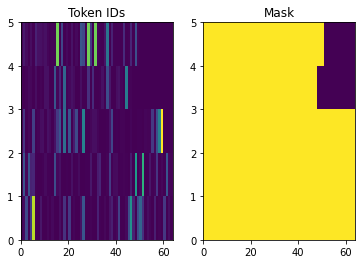

In [54]:
plt.subplot(1, 2, 1)
plt.pcolormesh(item_doc[0])
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(item_doc[0] != 0)
plt.title('Mask')

### Converting ID to Vector

In [55]:
user_df['reviewText'][0][0]

"My grandmother always had cashews in pretty glass containers in her living room. She loved cashews and lived to her late 80's eating them. I grew up on them. Now that we know that nuts are a healthy source of protein, they are a fairly non-guilty snack. Planters is a quality brand. This is our usual go-to brand when we want cashews. If you can eat about 1/8 cup at a time, they shouldn't destroy your diet."

In [56]:
input_vocab = enc_input_processor.get_vocabulary()
" ".join([input_vocab[id] for id in user_doc[0][0]])


'[START] my grandmother always had cashews in pretty glass containers in her living room . she loved cashews and lived to her late s eating them . i grew up on them . now that we know that nuts are a healthy source of protein , they are a fairly nonguilty snack . planters is a quality brand . this is our usual goto'

# **Context-aware Matrix Factorization for Rating Prediction**

In [57]:
#hyperparameters
num_users=len(user_to_row)
num_items=len(item_to_column)
mean_inv = np.float32( train_df['rating'].mean())



In [58]:
feature_num=128 # number of topics
units=int(feature_num/2 )# gru units

In [59]:
# del df
# del user_df
# del item_df
# del user_corpus[:]
# del item_corpus[:]
# del train_df
# del test_df

# gc.collect()
# gc.collect(0)
# gc.collect(1)
# gc.collect(2)

In [60]:
user_textual_features = np.zeros(shape=(num_users, feature_num),dtype=np.float32)
item_textual_features = np.zeros(shape=(num_items, feature_num),dtype=np.float32)

In [61]:
user_recommender_features = np.zeros(shape=(num_users, feature_num),dtype=np.float64)
item_recommender_features = np.zeros(shape=(num_items, feature_num),dtype=np.float64)

## **PMF (Probabilistic Matrix Factorization)**

In [62]:
class PMF():
    def __init__(self, num_feat=16, epsilon=1, _lambda=0.15, momentum=0.8,  batch_size=1024,num_item=9000,num_user=15000,mean_inv=3):
        self.num_feat = num_feat  # Number of latent features,
        self.epsilon = epsilon  # learning rate,
        self._lambda = _lambda  # L2 regularization,
        self.momentum = momentum  # momentum of the gradient,
        self.batch_size = batch_size  # Number of training samples used in each batches (for SGD optimization)
        self.num_item=num_item
        self.num_user=num_user
        self.V =  0.1 * np.random.randn(self.num_item, self.num_feat).astype(np.float64)  # Item feature vectors
        self.U =  0.1 * np.random.randn(self.num_user, self.num_feat).astype(np.float64)  # User feature vectors
        self.V_inc = np.zeros((self.num_item, self.num_feat),dtype=np.float64)
        self.U_inc = np.zeros((self.num_user, self.num_feat),dtype=np.float64)
        self.rmse_train = []
        self.rmse_test = []
        self.mean_inv= mean_inv  
        
    # ***Fit the model with train_tuple and evaluate RMSE on both train and test data.  ***********#
    # ***************** train_vec=TrainData, test_vec=TestData*************#
    def train(self):
            
            for batch_UserID,batch_ItemID, batch_rating  in train_ds_pmf:
                  
                # Compute Objective Function             
                pred_out = np.sum(np.multiply(self.U[batch_UserID, :],
                                              self.V[batch_ItemID, :]),
                                  axis=1)  # mean_inv subtracted # np.multiply
                
                rawErr = pred_out - batch_rating.numpy() + self.mean_inv

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.V[batch_ItemID, :]) \
                       + self._lambda * (self.U[batch_UserID, :] - user_textual_features[batch_UserID,:] )
                Ix_Item = 2 * np.multiply(rawErr[:, np.newaxis], self.U[batch_UserID, :]) \
                       + self._lambda * (self.V[batch_ItemID, :] - item_textual_features[batch_ItemID,:] ) 
                       # np.newaxis :increase the dimension
               
                dw_Item = np.zeros((self.num_item, self.num_feat))
                dw_User = np.zeros((self.num_user, self.num_feat))
                
                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Item[batch_ItemID[i], :] += Ix_Item[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
              
                self.V_inc = self.momentum * self.V_inc + self.epsilon * dw_Item / self.batch_size
                self.U_inc = self.momentum * self.U_inc + self.epsilon * dw_User / self.batch_size
                
                self.V = self.V - self.V_inc
                self.U = self.U - self.U_inc
            
                # Compute Objective Function after
            self.evaluate()
            self.update_recommender_features()
    
    
    def evaluate(self):
            rawErr=np.zeros((self.batch_size),dtype=np.float64).tolist()
            for batch_UserID,batch_ItemID, batch_rating  in train_ds_pmf:
                        
                pred_out = np.sum(np.multiply(self.U[batch_UserID, :],
                                        self.V[batch_ItemID, :]),
                                axis=1)  # mean_inv subtracted

                rawErr += pred_out - batch_rating.numpy() + self.mean_inv
        
            obj = np.linalg.norm(rawErr) ** 2 \
                    + 0.5 * self._lambda * (np.linalg.norm(self.U - user_textual_features) ** 2 + np.linalg.norm(self.V - item_textual_features) ** 2)

            self.rmse_train.append(np.sqrt(obj / train_data_num))

           # Compute test error
            rawErr=np.zeros((self.batch_size),dtype=np.float64).tolist()
            for batch_UserID,batch_ItemID, batch_rating  in test_ds_pmf:
                pred_out = np.sum(np.multiply(self.U[batch_UserID, :],
                                        self.V[batch_ItemID, :]),
                                axis=1)  # mean_inv subtracted

                rawErr += pred_out - batch_rating.numpy() + self.mean_inv

            self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(test_data_num))

            # Print info
            print('\nTraining RMSE: %f, Test RMSE %f' % (self.rmse_train[-1], self.rmse_test[-1]))


    def update_recommender_features(self,):
        user_recommender_features = self.U
        item_recommender_features = self.V


# **Adversarial Seq2Seq Learning**

## **Metrics**

In [63]:
# log files for training and test
train_log_dir = 'logs/gradient_tape/'  + '/train'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_log_dir = 'logs/gradient_tape/'  + '/test'
test_summary_writer = tf.summary.create_file_writer(test_log_dir)
graph_log_dir = 'logs/graph/'  
graph_summary_writer = tf.summary.create_file_writer(graph_log_dir)

In [64]:
class PerplexityMetric(tf.keras.metrics.Metric):
    def __init__(self,name='perplexity',**kwargs):
        super().__init__(name=name, **kwargs)
        self.perplexity=self.add_weight(name='pl',initializer='zeros')

    def update_state(self, nll_loss):
        self.perplexity= 2 ** nll_loss

    def result(self):
        return self.perplexity

In [65]:
train_plx_gen_tch = PerplexityMetric(name='generator perplexity')  # teacher forcing mode
train_plx_gen_plc = PerplexityMetric(name='generator perplexity')  # policy gradient mode
train_acc_dis = tf.keras.metrics.BinaryAccuracy(threshold=0.5)

test_plx_gen = PerplexityMetric(name='generator perplexity')  



## **Recurrent Review Generator**

- it consists of two encoders and one decoder

### **Encoder**

In [66]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self,vocab_size, embedding_dim, enc_units):
    super().__init__()
    self.enc_units = enc_units
    self.embedding_dim=embedding_dim
    self.vocab_size = vocab_size
    
    self.embedding = tf.keras.layers.Embedding( self.vocab_size, self.embedding_dim, embeddings_initializer=keras.initializers.Constant(full_embedding_matrix),trainable=False)
    self.gru= tf.keras.layers.Bidirectional(tf.keras.layers.GRU(  self.enc_units,return_state=True,  recurrent_initializer='glorot_uniform' ))


  def call(self, reviews, state=None):
    vectors = self.embedding(reviews)
    _,encoder_forward_state,encoder_backward_state  = self.gru(vectors, initial_state=state)
 
    return  tf.concat([ encoder_forward_state, encoder_backward_state],-1)

    

### **Decoder (Generator)**

In [67]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self,vocab_size, embedding_dim, dec_units):
    super().__init__()
    self.dec_units = dec_units
    self.embedding_dim = embedding_dim
    self.vocab_size = vocab_size
    
    self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim,embeddings_initializer=keras.initializers.Constant(full_embedding_matrix), trainable=False)
    self.gru=tf.keras.layers.GRU( self.dec_units , return_state=True,return_sequences=True)
    self.fc = tf.keras.layers.Dense(self.vocab_size, use_bias=False)
    self.sf=tf.keras.layers.Activation('softmax')

  def call(self, decoder_input, context_vector,state=None):

     embedded_input = self.embedding(decoder_input)
     joint_input_context = tf.concat([embedded_input, tf.tile(tf.expand_dims(context_vector,1),[1,embedded_input.shape[1],1])],2 )
     outputs,dec_state = self.gru(joint_input_context, initial_state=state)
     logits = self.fc( outputs)
     prob_dist = self.sf(logits)

     return prob_dist,dec_state


In [68]:
class GeneratorLoss(tf.keras.losses.Loss):
  def __init__(self,vocab_size):
    self.name = 'masked_loss'
    self.vocab_size=vocab_size
    self.scce = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')

  def __call__(self, y_true, y_pred):
    # Calculating the loss for a batch of reviews.

    loss = self.scce(y_true,y_pred)
    mask = tf.cast(y_true != 0, loss.dtype)
    loss*=  mask
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

## **Discriminator**

In [69]:
class Discriminator(tf.keras.Model):
    def __init__( self, sequence_length, vocab_size, embedding_dim, filter_sizes, num_filters):
      super().__init__()
      self.sequence_length=sequence_length
      self.vocab_size=vocab_size
      self.embedding_dim=embedding_dim
      self.filter_sizes=filter_sizes
      self.num_filters= num_filters
      self.dis_dropout_keep_prob = 0.75

      self.embedding = tf.keras.layers.Embedding(self.vocab_size, self.embedding_dim,weights=[full_embedding_matrix],name="discriminator_embedding",trainable=False)
     
      self.conv_unigram= tf.keras.layers.Conv1D(self.num_filters, filter_sizes[0], activation="tanh",name="conv_unigram")
      self.conv_bigram= tf.keras.layers.Conv1D(self.num_filters, filter_sizes[1],activation="tanh",name="conv_bigram")
      self.conv_trigram= tf.keras.layers.Conv1D(self.num_filters, filter_sizes[2],activation="tanh",name="conv_trigram")
      self.conv_fourgram= tf.keras.layers.Conv1D(self.num_filters, filter_sizes[3],activation="tanh",name="conv_fourgram")
      self.conv_fivegram= tf.keras.layers.Conv1D(self.num_filters, filter_sizes[4],activation="tanh",name="conv_fivegram")

      self.gmp_unigram = tf.keras.layers.GlobalMaxPooling1D(name="gmp_unigram")
      self.gmp_bigram = tf.keras.layers.GlobalMaxPooling1D(name="gmp_bigram")
      self.gmp_trigram = tf.keras.layers.GlobalMaxPooling1D(name="gmp_trigram")
      self.gmp_fourgram = tf.keras.layers.GlobalMaxPooling1D(name="gmp_fourgram")
      self.gmp_fivegram = tf.keras.layers.GlobalMaxPooling1D(name="gmp_fivegram")

      self.dropout=tf.keras.layers.Dropout(self.dis_dropout_keep_prob,name="dropout")
      self.fc=tf.keras.layers.Dense(1,activation="sigmoid",use_bias= True)


    def get_reward(self, discriminator_inputs , context_vector,training=False ):
      
      embedded_input= self.embedding(discriminator_inputs)
      joint_input_context =tf.concat([embedded_input, tf.tile(tf.expand_dims(context_vector,1),[1,embedded_input.shape[1],1])],2 )

      cv_unigram=self.conv_unigram(joint_input_context)
      cv_bigram=self.conv_bigram(joint_input_context)
      cv_trigram=self.conv_trigram(joint_input_context)
      cv_fourgram=self.conv_fourgram(joint_input_context)
      cv_fivegram=self.conv_fivegram(joint_input_context)

      gmp_unigram = self.gmp_unigram(cv_unigram)
      gmp_bigram = self.gmp_bigram(cv_bigram)
      gmp_trigram =  self.gmp_trigram(cv_trigram)
      gmp_fourgram = self.gmp_fourgram(cv_fourgram)
      gmp_fivegram = self.gmp_fivegram(cv_fivegram)
    
      gmp_overal = tf.concat([gmp_unigram,gmp_bigram,gmp_trigram,gmp_fourgram,gmp_fivegram],1)
      
      if training:
        dropout = self.dropout(gmp_overal,training=training)
        ath= self.fc(dropout)
        gc.collect()
        return ath[:,0],self.fc.weights[0][:,0],self.fc.bias
      else:
        ath= self.fc(gmp_overal)
        gc.collect()
        return ath[:,0]



In [70]:
class DiscriminatorLoss(tf.keras.losses.Loss):
  def __init__(self):
    self.name = 'cross-entropy_loss'
    self.bce = tf.keras.losses.BinaryCrossentropy( reduction='none')

  def __call__(self, y_true, y_pred):

    loss = self.bce(y_true, y_pred)
    return loss

## **Seq2Seq Model**

In [71]:
class MaskedLossReward(tf.keras.losses.Loss):
  def __init__(self,vocab_size):
    self.name = 'masked_loss_reward'
    self.vocab_size=vocab_size
    self.scce = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')

  def __call__(self, y_true, y_pred,reward):
    # Calculate the loss for each step.

    loss = self.scce(y_true,y_pred)
    mask = tf.cast(y_true != 0, loss.dtype)
    loss*=  mask
    loss *= reward
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

In [72]:
class Seq2Seq(tf.keras.Model): 
    def __init__(self,num_topic,num_item ,num_user, units ,embedding_dim,vocab_size ,sequence_length, num_batches,num_batches_test, batch_size, use_tf_function=False):
        super().__init__()
        self.use_tf_function = use_tf_function
        self.num_batches_test = num_batches_test
        self.num_batches = num_batches # train batch number
        self.batch_size = batch_size
        self.num_topic = num_topic
        self.embedding_dim = embedding_dim
        self.units = units
        self.vocab_size = vocab_size
        self.sequence_length = sequence_length
        self.num_item = num_item
        self.num_user = num_user
        self.alpha = 10.0
        self.disc_l2_reg_lambda = 0.2
        self.user_encoder = Encoder(vocab_size= self.vocab_size,  embedding_dim= self.embedding_dim, enc_units= self.units)
        self.item_encoder = Encoder(vocab_size= self.vocab_size,  embedding_dim= self.embedding_dim, enc_units= self.units)
        self.decoder = Decoder(vocab_size= self.vocab_size,  embedding_dim= self.embedding_dim, dec_units= 4 * self.units) #generator
        self.discriminator = Discriminator(sequence_length= self.sequence_length, vocab_size= self.vocab_size,embedding_dim= self.embedding_dim, filter_sizes= [1, 2, 3 ,4, 5] ,num_filters=128)
      
        self.loss_gn = GeneratorLoss(vocab_size=self.vocab_size)
        self.loss_ds = DiscriminatorLoss()
        self.loss_fn = MaskedLossReward(vocab_size=self.vocab_size) # generator loss with reward

        self.optimizer_gn = tf.optimizers.Adam(1e-4)
        self.optimizer_ds = tf.optimizers.Adam(1e-4)

    def generate_textual_features(self):
            
          for start_index in range(0, self.num_user, self.batch_size):
            end_index = min(start_index + self.batch_size, self.num_user)                           
            batch_userID = np.arange(start_index, end_index)

            # fetch a batch of user doc
            batch_userdoc_flattend=[]
            userdoc_slice_idx=[0]
            for doc_id in batch_userID:
              userdoc_slice_idx.append(userdoc_slice_idx[-1] + user_doc[doc_id].shape[0])
              batch_userdoc_flattend = np.append(batch_userdoc_flattend,user_doc[doc_id])
            batch_userdoc = tf.reshape(tf.convert_to_tensor( batch_userdoc_flattend,dtype=tf.int32),[userdoc_slice_idx[-1],self.sequence_length])

            user_enc_state = self.user_encoder(batch_userdoc) # user vector representations      
            user_context_vector = tf.stack([ tf.reduce_mean(user_enc_state[ userdoc_slice_idx[sl_num] : userdoc_slice_idx[sl_num+1] ],0) for  sl_num in range(len(batch_userID))])
            
            user_textual_features[batch_userID]=user_context_vector.numpy()
            
          for start_index in range(0, self.num_item, self.batch_size):
            end_index = min(start_index + self.batch_size, self.num_item)                           
            batch_itemID = np.arange(start_index, end_index)

            # fetch a batch of item doc
            batch_itemdoc_flattend=[]
            itemdoc_slice_idx=[0]
            for doc_id in batch_itemID:
              itemdoc_slice_idx.append(itemdoc_slice_idx[-1] + item_doc[doc_id].shape[0])
              batch_itemdoc_flattend = np.append(batch_itemdoc_flattend,item_doc[doc_id])
            batch_itemdoc = tf.reshape(tf.convert_to_tensor( batch_itemdoc_flattend,dtype=tf.int32),[itemdoc_slice_idx[-1],self.sequence_length])
            
            item_enc_state = self.item_encoder(batch_itemdoc) # item vector representations
            item_context_vector = tf.stack([ tf.reduce_mean(item_enc_state[ itemdoc_slice_idx[sl_num] : itemdoc_slice_idx[sl_num+1] ],0) for  sl_num in range(len(batch_itemID))])
            
            item_textual_features[batch_itemID]=item_context_vector.numpy()
    
    def teacher_forcing_train(self,num_steps=1):
          total_gen_loss=0
          for t_step in range(num_steps):
 
            (batch_userID,batch_itemID ,batch_review_in,batch_review_out) = next(iter(train_ds_seq))
            # fetch a batch of user doc
            batch_userdoc_flattend=[]
            userdoc_slice_idx=[0]
            for doc_id in batch_userID:
              userdoc_slice_idx.append(userdoc_slice_idx[-1] + user_doc[doc_id].shape[0])
              batch_userdoc_flattend = np.append(batch_userdoc_flattend,user_doc[doc_id])
            batch_userdoc = tf.reshape(tf.convert_to_tensor( batch_userdoc_flattend,dtype=tf.int32),[userdoc_slice_idx[-1],self.sequence_length])

            # fetch a batch of item doc
            batch_itemdoc_flattend=[]
            itemdoc_slice_idx=[0]
            for doc_id in batch_itemID:
              itemdoc_slice_idx.append(itemdoc_slice_idx[-1] + item_doc[doc_id].shape[0])
              batch_itemdoc_flattend = np.append(batch_itemdoc_flattend,item_doc[doc_id])
            batch_itemdoc = tf.reshape(tf.convert_to_tensor( batch_itemdoc_flattend,dtype=tf.int32),[itemdoc_slice_idx[-1],self.sequence_length])
            
            with tf.GradientTape() as tape1 , tf.GradientTape() as tape2:
              tape1.watch(self.user_encoder.trainable_variables + self.item_encoder.trainable_variables)
              tape2.watch(self.decoder.trainable_variables)
              
              user_enc_state = self.user_encoder(batch_userdoc) # user vector representations      
              item_enc_state = self.item_encoder(batch_itemdoc) # item vector representations
                
              user_context_vector = tf.stack([ tf.reduce_mean(user_enc_state[ userdoc_slice_idx[sl_num] : userdoc_slice_idx[sl_num+1] ],0) for  sl_num in range(self.batch_size)])
              item_context_vector = tf.stack([ tf.reduce_mean(item_enc_state[ itemdoc_slice_idx[sl_num] : itemdoc_slice_idx[sl_num+1] ],0) for  sl_num in range(self.batch_size)])
              context_vector = tf.concat( [user_context_vector,item_context_vector],1)
                           
              # regularization 
              user_regularization_loss= (np.linalg.norm( user_recommender_features[batch_userID.numpy()] - user_context_vector.numpy()) ** 2) /  user_context_vector.shape[0] 
              item_regularization_loss= (np.linalg.norm( item_recommender_features[batch_itemID.numpy()] - item_context_vector.numpy()) ** 2) /  item_context_vector.shape[0] 
              
              regularization_loss = tf.constant( self.alpha * (user_regularization_loss + item_regularization_loss) )
              dec_pred, _ = self.decoder( batch_review_in , context_vector)             
              gen_loss = self.loss_gn(batch_review_out , dec_pred)
           
            grad_enc = tape1.gradient([gen_loss,regularization_loss],self.user_encoder.trainable_variables + self.item_encoder.trainable_variables )
            grad_dec = tape2.gradient(gen_loss,self.decoder.trainable_variables )

            self.optimizer_gn.apply_gradients(zip(grad_enc+grad_dec, self.user_encoder.trainable_variables + self.item_encoder.trainable_variables+self.decoder.trainable_variables ))                 
            
            total_gen_loss += gen_loss
            # total_regularization_loss += regularization_loss
            if t_step % 10 == 0:
              print("batch number: ",t_step,"\tgen loss: ", gen_loss.numpy())
    
          train_plx_gen_tch.update_state(total_gen_loss / num_steps)

    def test(self,num_steps):
        total_loss=0
        for step in range(num_steps):
            (batch_userID,batch_itemID ,_,_) = next(iter(test_ds_seq))
            context_vector = tf.concat([user_textual_features[batch_userID.numpy()],item_textual_features[batch_itemID.numpy()]],1)                    
            predicted_samples,dec_prob = self.generate_sample(context_vector=context_vector)
            loss = self.loss_gn(predicted_samples ,tf.transpose( tf.stack(dec_prob), [1,0,2])  )
            total_loss += loss
            if step % 4 == 0:
              print("batch number: ",step, "\tgen loss: ",loss.numpy())

        test_plx_gen.update_state(total_loss / num_steps)
  

    
    def adversarial_train(self,num_steps=1):
        total_gen_loss=0
        train_acc_dis.reset_state()
        for step in range(num_steps):
          # train generator for one step
          generated_samples,batch_userID,batch_itemID, gen_loss =  self._train_step_gn_policy() #adversarial samples
          total_gen_loss += gen_loss
          # train discriminator for one step
          disc_loss = self._train_step_disc(generated_samples,batch_userID,batch_itemID)
          if step % 5 == 0:
            print("batch number: ",step, "\t\tgen loss: ",gen_loss.numpy(),"\t\t\tdisc loss: ",disc_loss.numpy())   
        train_plx_gen_plc.update_state(total_gen_loss / num_steps)


    def _train_step_gn_policy(self):
            batch_userID = np.random.choice(range(0,self.num_user),self.batch_size).astype('int32')
            batch_itemID = np.random.choice(range(0,self.num_item),self.batch_size).astype('int32') 
            with tf.GradientTape() as tape:

              context_vector = tf.concat([user_textual_features[batch_userID],item_textual_features[batch_itemID]],1)                    
              generated_samples,dec_prob = self.generate_sample(context_vector=context_vector)            
              reward = self.discriminator.get_reward(generated_samples,context_vector)   # batchsize             
              g_loss = self.loss_fn(generated_samples , tf.transpose( tf.stack(dec_prob) , [1,0,2]) ,tf.tile( tf.expand_dims(reward,1),[1,self.sequence_length]).numpy() )
            
            variables =  self.decoder.trainable_variables 
            gradients = tape.gradient(g_loss, variables)                  
            self.optimizer_gn.apply_gradients(zip(gradients, variables))
            
            return generated_samples,batch_userID,batch_itemID,g_loss
       
    def _train_step_disc(self,negative_data,negative_user_indices,negative_item_indices):

          with tf.GradientTape() as tape:
            (positive_user_indices,positive_item_indices,_,positive_data) = next(iter(train_ds_seq)) # ground-truth data

            #data shape (batch_size * seq length)
            whole_user_indices = tf.concat([positive_user_indices,negative_user_indices],0)
            whole_item_indices = tf.concat([positive_item_indices,negative_item_indices],0)

            positive_labels = tf.zeros(batch_size, dtype=tf.int32) 
            negative_labels = tf.ones(batch_size, dtype=tf.int32) 
            labels = tf.concat([positive_labels, negative_labels], 0)

            shuffle_indices = tf.random.shuffle( tf.range(0, len(labels),dtype=tf.int32))
            whole_data = tf.gather(tf.concat([positive_data,negative_data],0),shuffle_indices)    
            labels = tf.gather(labels,shuffle_indices)
            whole_user_indices = tf.gather(whole_user_indices,shuffle_indices)
            whole_item_indices = tf.gather(whole_item_indices,shuffle_indices)
            query_embedding = tf.concat([tf.gather(user_textual_features , whole_user_indices) ,tf.gather( item_textual_features , whole_item_indices)], 1)
            # query shape (batch_size ,2.feature_num)
            dis_reward,weights,bias = self.discriminator.get_reward( whole_data,query_embedding,training=True)
            l2_loss = tf.nn.l2_loss(2 * weights) + tf.nn.l2_loss(bias)
            disc_loss = self.loss_ds(labels,dis_reward) + (self.disc_l2_reg_lambda * l2_loss)
         
          variables = self.discriminator.trainable_variables 
          gradients = tape.gradient(disc_loss, variables)
          self.optimizer_ds.apply_gradients(zip(gradients, variables))

          train_acc_dis.update_state(labels,dis_reward)
          return disc_loss


    def generate_sample(self, context_vector ):
   
        dec_out = [tf.convert_to_tensor(context_vector.shape[0] * [[2]])]
        dec_prob=[]
        dec_state=None    
        for _ in range(self.sequence_length):           
            d_prob,dec_state = self.decoder( dec_out[-1], context_vector ,dec_state)          
            dec_prob.append(d_prob[:,-1])   
            dec_out.append(tf.random.categorical(d_prob[:,-1],1,dtype=tf.int32))            
            del d_prob          
        gc.collect()
        
        return tf.squeeze(tf.stack(dec_out,1))[:,1:], dec_prob 


    
    def train(self,current_step):
        print("\n\nTeacher Forcing Train:")
        self.teacher_forcing_train(num_steps= 16)  # t step
        if current_step > -1:
          print("\n\nAdversarial Train:")          
          self.adversarial_train(num_steps= 4)     # g step
        print("\n\nGenerator Test:")          
        self.test(num_steps= self.num_batches_test)
       


# **Multi-Task Learning**

In [73]:
class MultiTaskModel(tf.keras.Model):
      def __init__(self):
        super().__init__()
        self.pmf_model = PMF(num_feat=feature_num,num_item= num_items ,num_user= num_users, mean_inv=mean_inv)
        self.seq2seq_model = Seq2Seq(num_topic=feature_num,num_item= num_items ,num_user= num_users,units=units, embedding_dim= embedding_dim,vocab_size=full_embedding_matrix.shape[0],sequence_length=sequence_length, num_batches= num_batches,num_batches_test=num_batches_test,batch_size= batch_size)      
     
      def train(self,n_epochs):    
          ckpt.restore(manager.latest_checkpoint)
          if manager.latest_checkpoint:
            print("Restored from {}".format(manager.latest_checkpoint))
          else:
            print("Initializing from scratch.")
          #tf.profiler.experimental.start('logs')
          for epoch in range(n_epochs):
              print("\n\nepoch : ", int(ckpt.step))
              self.seq2seq_model.generate_textual_features()

              print("********************************************* PMF Model Training Turn *********************************************")
              self.pmf_model.train()
              print("\n\n******************************************* Seq2Seq Model Training Turn *******************************************")                                         
              self.seq2seq_model.train(int(ckpt.step))
             
              with train_summary_writer.as_default():
                  tf.summary.scalar('Training perplexity for generator in Teacher Forcing mode', train_plx_gen_tch.result(), step=int(ckpt.step))
                  tf.summary.scalar('Training perplexity for generator in Policy Gradient mode', train_plx_gen_plc.result(), step=int(ckpt.step))
                  tf.summary.scalar('Training accuracy for discriminator', train_acc_dis.result(), step=int(ckpt.step))
                  
              with test_summary_writer.as_default():
                  tf.summary.scalar('Test perplexity for generator', test_plx_gen.result(), step=int(ckpt.step))
  
              ckpt.step.assign_add(1)
              if int(ckpt.step) % 10 ==0:
                save_path = manager.save()
                print("Saved checkpoint for epoch {}: {}".format(int(ckpt.step), save_path))
            
          #tf.profiler.experimental.stop()


In [74]:
gc.collect()
gc.collect(0)
gc.collect(1)
gc.collect(2)

# creating an instance of Multi_Task Model
mt_model = MultiTaskModel()
ckpt = tf.train.Checkpoint(step=tf.Variable(0), optimizer=tf.keras.optimizers.Adam(), net=mt_model)
manager = tf.train.CheckpointManager(ckpt, './tf_ckpts', max_to_keep=6000)


In [79]:
mt_model.train(n_epochs=3000)

Restored from ./tf_ckpts/ckpt-2


epoch :  20
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:14:14.113540: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:14:14.129681: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.879698, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.360866
batch number:  10 	gen loss:  6.328337


Adversarial Train:
batch number:  0 		gen loss:  7.3285007 			disc loss:  0.9710573


Generator Test:
batch number:  0 	gen loss:  9.405975
batch number:  4 	gen loss:  9.3888235
batch number:  8 	gen loss:  9.393847
batch number:  12 	gen loss:  9.368016
batch number:  16 	gen loss:  9.419943
batch number:  20 	gen loss:  9.294751


epoch :  21
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:14:29.490753: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.902280, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2672744
batch number:  10 	gen loss:  6.471242


Adversarial Train:
batch number:  0 		gen loss:  7.4511123 			disc loss:  0.9530606


Generator Test:
batch number:  0 	gen loss:  9.4292345
batch number:  4 	gen loss:  9.453842
batch number:  8 	gen loss:  9.378931
batch number:  12 	gen loss:  9.41279
batch number:  16 	gen loss:  9.391293
batch number:  20 	gen loss:  9.371494


epoch :  22
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.909929, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2773204


2022-12-18 10:14:44.887255: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


batch number:  10 	gen loss:  6.292012


Adversarial Train:
batch number:  0 		gen loss:  7.0621734 			disc loss:  0.9357164


Generator Test:
batch number:  0 	gen loss:  9.427204
batch number:  4 	gen loss:  9.3754015
batch number:  8 	gen loss:  9.451138
batch number:  12 	gen loss:  9.413824
batch number:  16 	gen loss:  9.416494
batch number:  20 	gen loss:  9.457578


epoch :  23
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:15:00.223570: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.930355, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.291342
batch number:  10 	gen loss:  6.2095127


Adversarial Train:
batch number:  0 		gen loss:  7.4619823 			disc loss:  0.89091146


Generator Test:
batch number:  0 	gen loss:  9.412962
batch number:  4 	gen loss:  9.440087
batch number:  8 	gen loss:  9.389194
batch number:  12 	gen loss:  9.427068
batch number:  16 	gen loss:  9.393644
batch number:  20 	gen loss:  9.466146


epoch :  24
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.943105, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.4992294
batch number:  10 	gen loss:  6.42889


A

2022-12-18 10:15:30.943569: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.951973, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2264814
batch number:  10 	gen loss:  6.383242


Adversarial Train:
batch number:  0 		gen loss:  7.5708623 			disc loss:  0.93256277


Generator Test:
batch number:  0 	gen loss:  9.431897
batch number:  4 	gen loss:  9.436109
batch number:  8 	gen loss:  9.484731
batch number:  12 	gen loss:  9.404142
batch number:  16 	gen loss:  9.441756
batch number:  20 	gen loss:  9.415806


epoch :  26
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.958435, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.3579907
batch number:  10 	gen loss:  6.2256546



2022-12-18 10:16:01.033661: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:16:01.051779: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.955109, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.288021
batch number:  10 	gen loss:  6.234245


Adversarial Train:
batch number:  0 		gen loss:  7.760518 			disc loss:  0.8674736


Generator Test:
batch number:  0 	gen loss:  9.413707
batch number:  4 	gen loss:  9.465059
batch number:  8 	gen loss:  9.536841
batch number:  12 	gen loss:  9.402872
batch number:  16 	gen loss:  9.474394
batch number:  20 	gen loss:  9.482113


epoch :  28
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:16:16.474657: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.968050, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.368869
batch number:  10 	gen loss:  6.281488


Adversarial Train:
batch number:  0 		gen loss:  7.985259 			disc loss:  0.84688175


Generator Test:
batch number:  0 	gen loss:  9.448992
batch number:  4 	gen loss:  9.518636
batch number:  8 	gen loss:  9.538161
batch number:  12 	gen loss:  9.413977
batch number:  16 	gen loss:  9.427868
batch number:  20 	gen loss:  9.470406


epoch :  29
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.968445, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.172269
batch number:  10 	gen loss:  6.2636185


Ad

2022-12-18 10:17:44.809483: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:17:44.817403: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.983902, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.257028
batch number:  10 	gen loss:  6.2712984


Adversarial Train:
batch number:  0 		gen loss:  7.9403896 			disc loss:  0.84020317


Generator Test:
batch number:  0 	gen loss:  9.4862385
batch number:  4 	gen loss:  9.480183
batch number:  8 	gen loss:  9.504729
batch number:  12 	gen loss:  9.547108
batch number:  16 	gen loss:  9.523131
batch number:  20 	gen loss:  9.48552


epoch :  35
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.990250, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.275521
batch number:  10 	gen loss:  6.299051


A

2022-12-18 10:18:27.791090: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:18:27.799078: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.982626, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.3353724
batch number:  10 	gen loss:  6.1861076


Adversarial Train:
batch number:  0 		gen loss:  8.081358 			disc loss:  0.74921906


Generator Test:
batch number:  0 	gen loss:  9.526111
batch number:  4 	gen loss:  9.461253
batch number:  8 	gen loss:  9.447353
batch number:  12 	gen loss:  9.461469
batch number:  16 	gen loss:  9.4850445
batch number:  20 	gen loss:  9.525976


epoch :  38
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:18:42.290918: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.977274, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2903733
batch number:  10 	gen loss:  6.158684


Adversarial Train:
batch number:  0 		gen loss:  7.9179106 			disc loss:  0.7309096


Generator Test:
batch number:  0 	gen loss:  9.482026
batch number:  4 	gen loss:  9.490681
batch number:  8 	gen loss:  9.477136
batch number:  12 	gen loss:  9.486146
batch number:  16 	gen loss:  9.424507
batch number:  20 	gen loss:  9.548144


epoch :  39
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.960566, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.255274
batch number:  10 	gen loss:  6.265963


Ad

2022-12-18 10:19:11.255717: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.939267, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2735972
batch number:  10 	gen loss:  6.333999


Adversarial Train:
batch number:  0 		gen loss:  8.334957 			disc loss:  0.72524786


Generator Test:
batch number:  0 	gen loss:  9.353483
batch number:  4 	gen loss:  9.451221
batch number:  8 	gen loss:  9.455512
batch number:  12 	gen loss:  9.424515
batch number:  16 	gen loss:  9.37211
batch number:  20 	gen loss:  9.352058


epoch :  41
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.915777, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.375932
batch number:  10 	gen loss:  6.185857


Adv

2022-12-18 10:20:23.143430: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:20:23.155065: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.757339, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2555428
batch number:  10 	gen loss:  6.2157598


Adversarial Train:
batch number:  0 		gen loss:  8.349657 			disc loss:  0.7012067


Generator Test:
batch number:  0 	gen loss:  9.442803
batch number:  4 	gen loss:  9.393724
batch number:  8 	gen loss:  9.446673
batch number:  12 	gen loss:  9.458471
batch number:  16 	gen loss:  9.453194
batch number:  20 	gen loss:  9.448338


epoch :  46
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:20:37.588015: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:20:37.601305: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.749563, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.263477
batch number:  10 	gen loss:  6.2188287


Adversarial Train:
batch number:  0 		gen loss:  8.359975 			disc loss:  0.6721979


Generator Test:
batch number:  0 	gen loss:  9.486345
batch number:  4 	gen loss:  9.431577
batch number:  8 	gen loss:  9.477226
batch number:  12 	gen loss:  9.434576
batch number:  16 	gen loss:  9.378165
batch number:  20 	gen loss:  9.450827


epoch :  47
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.750876, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.296538
batch number:  10 	gen loss:  6.231449


Adv

2022-12-18 10:21:36.354568: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:21:36.361897: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.767345, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.31042
batch number:  10 	gen loss:  6.258762


Adversarial Train:
batch number:  0 		gen loss:  8.29008 			disc loss:  0.6803786


Generator Test:
batch number:  0 	gen loss:  9.50951
batch number:  4 	gen loss:  9.501814
batch number:  8 	gen loss:  9.478917
batch number:  12 	gen loss:  9.511037
batch number:  16 	gen loss:  9.559802
batch number:  20 	gen loss:  9.509382


epoch :  51
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.779804, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.307356
batch number:  10 	gen loss:  6.2730303


Advers

2022-12-18 10:22:20.298854: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


batch number:  10 	gen loss:  6.2993526


Adversarial Train:
batch number:  0 		gen loss:  8.416847 			disc loss:  0.66666424


Generator Test:
batch number:  0 	gen loss:  9.49981
batch number:  4 	gen loss:  9.527451
batch number:  8 	gen loss:  9.550852
batch number:  12 	gen loss:  9.587485
batch number:  16 	gen loss:  9.498099
batch number:  20 	gen loss:  9.497066


epoch :  54
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:22:34.860679: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:22:34.871786: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.834145, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.321064
batch number:  10 	gen loss:  6.235274


Adversarial Train:
batch number:  0 		gen loss:  8.263021 			disc loss:  0.6523396


Generator Test:
batch number:  0 	gen loss:  9.501143
batch number:  4 	gen loss:  9.539418
batch number:  8 	gen loss:  9.492176
batch number:  12 	gen loss:  9.515113
batch number:  16 	gen loss:  9.541795
batch number:  20 	gen loss:  9.534428


epoch :  55
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:22:49.526135: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:22:49.535544: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.845471, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2857566
batch number:  10 	gen loss:  6.2344456


Adversarial Train:
batch number:  0 		gen loss:  8.003906 			disc loss:  0.6777593


Generator Test:
batch number:  0 	gen loss:  9.497583
batch number:  4 	gen loss:  9.509647
batch number:  8 	gen loss:  9.518266
batch number:  12 	gen loss:  9.488382
batch number:  16 	gen loss:  9.53308
batch number:  20 	gen loss:  9.510151


epoch :  56
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.868232, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.200861
batch number:  10 	gen loss:  6.235212


Adv

2022-12-18 10:23:18.343387: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:23:18.355469: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.881880, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.156247
batch number:  10 	gen loss:  6.2801967


Adversarial Train:
batch number:  0 		gen loss:  8.58125 			disc loss:  0.59586704


Generator Test:
batch number:  0 	gen loss:  9.527956
batch number:  4 	gen loss:  9.477583
batch number:  8 	gen loss:  9.540006
batch number:  12 	gen loss:  9.516265
batch number:  16 	gen loss:  9.47908
batch number:  20 	gen loss:  9.549417


epoch :  58
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:23:33.117661: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:23:33.126031: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.900991, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.3097596
batch number:  10 	gen loss:  6.21376


Adversarial Train:
batch number:  0 		gen loss:  8.659312 			disc loss:  0.6223152


Generator Test:
batch number:  0 	gen loss:  9.506695
batch number:  4 	gen loss:  9.440325
batch number:  8 	gen loss:  9.489377
batch number:  12 	gen loss:  9.42545
batch number:  16 	gen loss:  9.522827
batch number:  20 	gen loss:  9.527721


epoch :  59
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.913384, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.3505254
batch number:  10 	gen loss:  6.2882566


Adv

2022-12-18 10:24:59.911909: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:24:59.922639: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.945131, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.293509
batch number:  10 	gen loss:  6.402426


Adversarial Train:
batch number:  0 		gen loss:  8.607013 			disc loss:  0.6080944


Generator Test:
batch number:  0 	gen loss:  9.457659
batch number:  4 	gen loss:  9.486336
batch number:  8 	gen loss:  9.4088545
batch number:  12 	gen loss:  9.426001
batch number:  16 	gen loss:  9.470843
batch number:  20 	gen loss:  9.449474


epoch :  65
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:25:14.045398: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:25:14.053333: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.962191, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.1588798
batch number:  10 	gen loss:  6.2749696


Adversarial Train:
batch number:  0 		gen loss:  8.576792 			disc loss:  0.58800673


Generator Test:
batch number:  0 	gen loss:  9.363681
batch number:  4 	gen loss:  9.447961
batch number:  8 	gen loss:  9.473111
batch number:  12 	gen loss:  9.449511
batch number:  16 	gen loss:  9.509232
batch number:  20 	gen loss:  9.429121


epoch :  66
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:25:28.372676: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.972937, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2924547
batch number:  10 	gen loss:  6.265977


Adversarial Train:
batch number:  0 		gen loss:  8.577767 			disc loss:  0.5895101


Generator Test:
batch number:  0 	gen loss:  9.452166
batch number:  4 	gen loss:  9.445481
batch number:  8 	gen loss:  9.522498
batch number:  12 	gen loss:  9.430862
batch number:  16 	gen loss:  9.330677
batch number:  20 	gen loss:  9.454057


epoch :  67
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:25:42.687434: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:25:42.703165: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.975849, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.200364
batch number:  10 	gen loss:  6.164773


Adversarial Train:
batch number:  0 		gen loss:  8.76895 			disc loss:  0.62566024


Generator Test:
batch number:  0 	gen loss:  9.451764
batch number:  4 	gen loss:  9.467002
batch number:  8 	gen loss:  9.45961
batch number:  12 	gen loss:  9.433374
batch number:  16 	gen loss:  9.406032
batch number:  20 	gen loss:  9.455607


epoch :  68
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.979497, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.278956
batch number:  10 	gen loss:  6.367988


Adver

2022-12-18 10:26:11.839362: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.983283, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.303424
batch number:  10 	gen loss:  6.3474326


Adversarial Train:
batch number:  0 		gen loss:  8.620988 			disc loss:  0.54297507


Generator Test:
batch number:  0 	gen loss:  9.440734
batch number:  4 	gen loss:  9.441041
batch number:  8 	gen loss:  9.434593
batch number:  12 	gen loss:  9.454558
batch number:  16 	gen loss:  9.369092
batch number:  20 	gen loss:  9.438761
Saved checkpoint for epoch 70: ./tf_ckpts/ckpt-7


epoch :  70
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.982203, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2

2022-12-18 10:26:41.508695: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:26:41.518996: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.983031, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2454367
batch number:  10 	gen loss:  6.2889204


Adversarial Train:
batch number:  0 		gen loss:  8.591831 			disc loss:  0.5658639


Generator Test:
batch number:  0 	gen loss:  9.431415
batch number:  4 	gen loss:  9.481212
batch number:  8 	gen loss:  9.462161
batch number:  12 	gen loss:  9.471585
batch number:  16 	gen loss:  9.506378
batch number:  20 	gen loss:  9.440681


epoch :  72
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.983399, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.4059806
batch number:  10 	gen loss:  6.2368417




2022-12-18 10:27:26.037678: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:27:26.046194: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.990903, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.410139
batch number:  10 	gen loss:  6.308615


Adversarial Train:
batch number:  0 		gen loss:  8.567253 			disc loss:  0.5316661


Generator Test:
batch number:  0 	gen loss:  9.400464
batch number:  4 	gen loss:  9.483015
batch number:  8 	gen loss:  9.449715
batch number:  12 	gen loss:  9.519094
batch number:  16 	gen loss:  9.5129595
batch number:  20 	gen loss:  9.502208


epoch :  75
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.990653, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2138066
batch number:  10 	gen loss:  6.192598


Ad

2022-12-18 10:28:10.200930: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:28:10.212517: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.987920, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2346544
batch number:  10 	gen loss:  6.2373934


Adversarial Train:
batch number:  0 		gen loss:  8.382186 			disc loss:  0.5523944


Generator Test:
batch number:  0 	gen loss:  9.512709
batch number:  4 	gen loss:  9.427268
batch number:  8 	gen loss:  9.462674
batch number:  12 	gen loss:  9.527158
batch number:  16 	gen loss:  9.49682
batch number:  20 	gen loss:  9.439148


epoch :  78
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:28:24.887762: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:28:24.895401: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.988153, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.3327413
batch number:  10 	gen loss:  6.2316985


Adversarial Train:
batch number:  0 		gen loss:  8.222429 			disc loss:  0.5180667


Generator Test:
batch number:  0 	gen loss:  9.470422
batch number:  4 	gen loss:  9.466426
batch number:  8 	gen loss:  9.446546
batch number:  12 	gen loss:  9.456944
batch number:  16 	gen loss:  9.416057
batch number:  20 	gen loss:  9.471735


epoch :  79
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.994214, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.203011
batch number:  10 	gen loss:  6.3107514


A

2022-12-18 10:29:08.427795: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 1.008905, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.194071
batch number:  10 	gen loss:  6.325898


Adversarial Train:
batch number:  0 		gen loss:  8.49478 			disc loss:  0.525619


Generator Test:
batch number:  0 	gen loss:  9.476411
batch number:  4 	gen loss:  9.427786
batch number:  8 	gen loss:  9.425721
batch number:  12 	gen loss:  9.488537
batch number:  16 	gen loss:  9.461766
batch number:  20 	gen loss:  9.407278


epoch :  82
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 1.011172, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.297803
batch number:  10 	gen loss:  6.262369


Advers

2022-12-18 10:30:07.317994: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:30:07.326160: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 1.014789, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.409897
batch number:  10 	gen loss:  6.272279


Adversarial Train:
batch number:  0 		gen loss:  8.14184 			disc loss:  0.50097716


Generator Test:
batch number:  0 	gen loss:  9.419719
batch number:  4 	gen loss:  9.395065
batch number:  8 	gen loss:  9.372348
batch number:  12 	gen loss:  9.369238
batch number:  16 	gen loss:  9.460016
batch number:  20 	gen loss:  9.415129


epoch :  86
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:30:21.759188: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:30:21.777340: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 1.021699, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2430444
batch number:  10 	gen loss:  6.2790103


Adversarial Train:
batch number:  0 		gen loss:  8.583544 			disc loss:  0.497538


Generator Test:
batch number:  0 	gen loss:  9.41804
batch number:  4 	gen loss:  9.403562
batch number:  8 	gen loss:  9.470395
batch number:  12 	gen loss:  9.42445
batch number:  16 	gen loss:  9.441184
batch number:  20 	gen loss:  9.405878


epoch :  87
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 1.020789, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2926154


2022-12-18 10:30:36.402218: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


batch number:  10 	gen loss:  6.2479377


Adversarial Train:
batch number:  0 		gen loss:  8.998566 			disc loss:  0.4706154


Generator Test:
batch number:  0 	gen loss:  9.446037
batch number:  4 	gen loss:  9.4157
batch number:  8 	gen loss:  9.341268
batch number:  12 	gen loss:  9.483141
batch number:  16 	gen loss:  9.425275
batch number:  20 	gen loss:  9.470436


epoch :  88
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:30:50.821842: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:30:50.830297: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 1.017957, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.3675017
batch number:  10 	gen loss:  6.255624


Adversarial Train:
batch number:  0 		gen loss:  9.091568 			disc loss:  0.45616212


Generator Test:
batch number:  0 	gen loss:  9.495984
batch number:  4 	gen loss:  9.449945
batch number:  8 	gen loss:  9.401454
batch number:  12 	gen loss:  9.400617
batch number:  16 	gen loss:  9.415968
batch number:  20 	gen loss:  9.451801


epoch :  89
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 1.013823, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.199736
batch number:  10 	gen loss:  6.23098


Adv

2022-12-18 10:31:19.904212: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:31:19.911828: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 1.001113, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.22277
batch number:  10 	gen loss:  6.32241


Adversarial Train:
batch number:  0 		gen loss:  8.651221 			disc loss:  0.4904448


Generator Test:
batch number:  0 	gen loss:  9.431215
batch number:  4 	gen loss:  9.386041
batch number:  8 	gen loss:  9.379879
batch number:  12 	gen loss:  9.338985
batch number:  16 	gen loss:  9.391188
batch number:  20 	gen loss:  9.387974


epoch :  91
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.971736, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.402909
batch number:  10 	gen loss:  6.3832254


Adver

2022-12-18 10:31:49.553554: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


batch number:  10 	gen loss:  6.387428


Adversarial Train:
batch number:  0 		gen loss:  8.628934 			disc loss:  0.44556236


Generator Test:
batch number:  0 	gen loss:  9.284229
batch number:  4 	gen loss:  9.308734
batch number:  8 	gen loss:  9.318947
batch number:  12 	gen loss:  9.270627
batch number:  16 	gen loss:  9.327231
batch number:  20 	gen loss:  9.279209


epoch :  93
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:32:04.166355: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:32:04.179057: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.886493, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.3617578
batch number:  10 	gen loss:  6.3728943


Adversarial Train:
batch number:  0 		gen loss:  8.392929 			disc loss:  0.4344619


Generator Test:
batch number:  0 	gen loss:  9.333126
batch number:  4 	gen loss:  9.319619
batch number:  8 	gen loss:  9.264532
batch number:  12 	gen loss:  9.244478
batch number:  16 	gen loss:  9.273179
batch number:  20 	gen loss:  9.292151


epoch :  94
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.848121, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2860203
batch number:  10 	gen loss:  6.3950644




2022-12-18 10:32:33.553983: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:32:33.571980: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.788092, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.4469385
batch number:  10 	gen loss:  6.2137933


Adversarial Train:
batch number:  0 		gen loss:  8.399881 			disc loss:  0.46648917


Generator Test:
batch number:  0 	gen loss:  9.408937
batch number:  4 	gen loss:  9.390892
batch number:  8 	gen loss:  9.361823
batch number:  12 	gen loss:  9.372538
batch number:  16 	gen loss:  9.373976
batch number:  20 	gen loss:  9.397549


epoch :  96
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:32:47.917407: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:32:47.925386: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.720933, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.318069
batch number:  10 	gen loss:  6.1998434


Adversarial Train:
batch number:  0 		gen loss:  9.141964 			disc loss:  0.46950668


Generator Test:
batch number:  0 	gen loss:  9.493931
batch number:  4 	gen loss:  9.578875
batch number:  8 	gen loss:  9.556373
batch number:  12 	gen loss:  9.549131
batch number:  16 	gen loss:  9.471521
batch number:  20 	gen loss:  9.540007


epoch :  97
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.725520, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.272801
batch number:  10 	gen loss:  6.2823067


A

2022-12-18 10:33:32.298883: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


batch number:  10 	gen loss:  6.182338


Adversarial Train:
batch number:  0 		gen loss:  8.667182 			disc loss:  0.42955902


Generator Test:
batch number:  0 	gen loss:  9.592017
batch number:  4 	gen loss:  9.592073
batch number:  8 	gen loss:  9.607881
batch number:  12 	gen loss:  9.55561
batch number:  16 	gen loss:  9.652433
batch number:  20 	gen loss:  9.60811
Saved checkpoint for epoch 100: ./tf_ckpts/ckpt-10


epoch :  100
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.816107, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.21181
batch number:  10 	gen loss:  6.2909107


Adversarial Train:
batch number:  0 		gen loss:  8.41219 			disc loss:  0.42663234


Generator Test:
batch number:  0 	gen loss:  9.576589
batch number:  4 	gen loss:  9.59134
bat

2022-12-18 10:34:16.576767: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:34:16.595025: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.899466, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2826514
batch number:  10 	gen loss:  6.4067693


Adversarial Train:
batch number:  0 		gen loss:  8.785156 			disc loss:  0.42076287


Generator Test:
batch number:  0 	gen loss:  9.615438
batch number:  4 	gen loss:  9.635215
batch number:  8 	gen loss:  9.5167675
batch number:  12 	gen loss:  9.608967
batch number:  16 	gen loss:  9.49418
batch number:  20 	gen loss:  9.647607


epoch :  103
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:34:31.233950: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:34:31.246969: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.941020, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2097154
batch number:  10 	gen loss:  6.201799


Adversarial Train:
batch number:  0 		gen loss:  9.195416 			disc loss:  0.403037


Generator Test:
batch number:  0 	gen loss:  9.583662
batch number:  4 	gen loss:  9.502528
batch number:  8 	gen loss:  9.559544
batch number:  12 	gen loss:  9.560331
batch number:  16 	gen loss:  9.582271
batch number:  20 	gen loss:  9.552594


epoch :  104
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:34:45.466356: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.975041, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.281949
batch number:  10 	gen loss:  6.2019215


Adversarial Train:
batch number:  0 		gen loss:  8.966024 			disc loss:  0.3890085


Generator Test:
batch number:  0 	gen loss:  9.638453
batch number:  4 	gen loss:  9.600098
batch number:  8 	gen loss:  9.555592
batch number:  12 	gen loss:  9.575353
batch number:  16 	gen loss:  9.557265
batch number:  20 	gen loss:  9.545333


epoch :  105
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 1.001662, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.1936727
batch number:  10 	gen loss:  6.2785


Adv

2022-12-18 10:35:29.331597: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 1.026489, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2453604
batch number:  10 	gen loss:  6.1776986


Adversarial Train:
batch number:  0 		gen loss:  8.713419 			disc loss:  0.41944334


Generator Test:
batch number:  0 	gen loss:  9.505574
batch number:  4 	gen loss:  9.601033
batch number:  8 	gen loss:  9.5155945
batch number:  12 	gen loss:  9.538986
batch number:  16 	gen loss:  9.5623455
batch number:  20 	gen loss:  9.553476


epoch :  108
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 1.036059, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.0688424
batch number:  10 	gen loss:  6.278276

2022-12-18 10:37:25.601709: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:37:25.610566: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 1.032253, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.207381
batch number:  10 	gen loss:  6.222763


Adversarial Train:
batch number:  0 		gen loss:  8.996907 			disc loss:  0.37134174


Generator Test:
batch number:  0 	gen loss:  9.495286
batch number:  4 	gen loss:  9.549421
batch number:  8 	gen loss:  9.452527
batch number:  12 	gen loss:  9.551113
batch number:  16 	gen loss:  9.527258
batch number:  20 	gen loss:  9.48212


epoch :  116
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:37:40.202506: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:37:40.210045: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.923674, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.300635
batch number:  10 	gen loss:  6.178267


Adversarial Train:
batch number:  0 		gen loss:  8.836181 			disc loss:  0.35763836


Generator Test:
batch number:  0 	gen loss:  9.509889
batch number:  4 	gen loss:  9.533127
batch number:  8 	gen loss:  9.5872135
batch number:  12 	gen loss:  9.508574
batch number:  16 	gen loss:  9.487192
batch number:  20 	gen loss:  9.53423


epoch :  117
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.888965, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.1526823
batch number:  10 	gen loss:  6.20942


Ad

2022-12-18 10:38:37.878547: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:38:37.885891: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.899311, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.3359385
batch number:  10 	gen loss:  6.254144


Adversarial Train:
batch number:  0 		gen loss:  8.901127 			disc loss:  0.35051674


Generator Test:
batch number:  0 	gen loss:  9.452821
batch number:  4 	gen loss:  9.579782
batch number:  8 	gen loss:  9.437457
batch number:  12 	gen loss:  9.473377
batch number:  16 	gen loss:  9.531166
batch number:  20 	gen loss:  9.4809475


epoch :  121
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:38:52.611428: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:38:52.617851: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.887494, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.326286
batch number:  10 	gen loss:  6.1835804


Adversarial Train:
batch number:  0 		gen loss:  8.966514 			disc loss:  0.33545765


Generator Test:
batch number:  0 	gen loss:  9.506221
batch number:  4 	gen loss:  9.557883
batch number:  8 	gen loss:  9.555821
batch number:  12 	gen loss:  9.529601
batch number:  16 	gen loss:  9.470693
batch number:  20 	gen loss:  9.518136


epoch :  122
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.881127, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.399763
batch number:  10 	gen loss:  6.2575207




2022-12-18 10:39:23.510829: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:39:23.530026: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.929422, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.1926723
batch number:  10 	gen loss:  6.2304063


Adversarial Train:
batch number:  0 		gen loss:  8.097822 			disc loss:  0.38207424


Generator Test:
batch number:  0 	gen loss:  9.575501
batch number:  4 	gen loss:  9.535783
batch number:  8 	gen loss:  9.566044
batch number:  12 	gen loss:  9.554401
batch number:  16 	gen loss:  9.604303
batch number:  20 	gen loss:  9.566909


epoch :  124
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 1.001528, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.254065
batch number:  10 	gen loss:  6.3123617



2022-12-18 10:40:09.328087: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:40:09.340911: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.963582, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2835116
batch number:  10 	gen loss:  6.198002


Adversarial Train:
batch number:  0 		gen loss:  9.187473 			disc loss:  0.37903452


Generator Test:
batch number:  0 	gen loss:  9.462157
batch number:  4 	gen loss:  9.467846
batch number:  8 	gen loss:  9.516722
batch number:  12 	gen loss:  9.518748
batch number:  16 	gen loss:  9.453275
batch number:  20 	gen loss:  9.481521


epoch :  127
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.931249, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.263529


2022-12-18 10:40:24.398012: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


batch number:  10 	gen loss:  6.414717


Adversarial Train:
batch number:  0 		gen loss:  9.223301 			disc loss:  0.46515837


Generator Test:
batch number:  0 	gen loss:  9.486922
batch number:  4 	gen loss:  9.517541
batch number:  8 	gen loss:  9.519613
batch number:  12 	gen loss:  9.477763
batch number:  16 	gen loss:  9.469366
batch number:  20 	gen loss:  9.45987


epoch :  128
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:40:39.437317: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:40:39.445784: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.939199, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.306304
batch number:  10 	gen loss:  6.2764583


Adversarial Train:
batch number:  0 		gen loss:  8.549641 			disc loss:  0.35213143


Generator Test:
batch number:  0 	gen loss:  9.491226
batch number:  4 	gen loss:  9.476445
batch number:  8 	gen loss:  9.454258
batch number:  12 	gen loss:  9.443928
batch number:  16 	gen loss:  9.450552
batch number:  20 	gen loss:  9.510895


epoch :  129
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:40:54.444895: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.933206, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.360258
batch number:  10 	gen loss:  6.2912745


Adversarial Train:
batch number:  0 		gen loss:  8.484711 			disc loss:  0.35409015


Generator Test:
batch number:  0 	gen loss:  9.474514
batch number:  4 	gen loss:  9.42407
batch number:  8 	gen loss:  9.4853735
batch number:  12 	gen loss:  9.427573
batch number:  16 	gen loss:  9.488422
batch number:  20 	gen loss:  9.458347
Saved checkpoint for epoch 130: ./tf_ckpts/ckpt-13


epoch :  130
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.828240, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  

2022-12-18 10:41:09.536056: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


batch number:  10 	gen loss:  6.2819123


Adversarial Train:
batch number:  0 		gen loss:  8.68354 			disc loss:  0.31717396


Generator Test:
batch number:  0 	gen loss:  9.46444
batch number:  4 	gen loss:  9.469519
batch number:  8 	gen loss:  9.424521
batch number:  12 	gen loss:  9.429929
batch number:  16 	gen loss:  9.470724
batch number:  20 	gen loss:  9.428483


epoch :  131
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:41:24.545381: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:41:24.552294: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.861108, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2946076
batch number:  10 	gen loss:  6.2613025


Adversarial Train:
batch number:  0 		gen loss:  8.879996 			disc loss:  0.34082562


Generator Test:
batch number:  0 	gen loss:  9.491876
batch number:  4 	gen loss:  9.534224
batch number:  8 	gen loss:  9.467302
batch number:  12 	gen loss:  9.531457
batch number:  16 	gen loss:  9.471823
batch number:  20 	gen loss:  9.471233


epoch :  132
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:41:39.749350: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.842650, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.3487806
batch number:  10 	gen loss:  6.3383613


Adversarial Train:
batch number:  0 		gen loss:  9.064034 			disc loss:  0.34494072


Generator Test:
batch number:  0 	gen loss:  9.4025345
batch number:  4 	gen loss:  9.46688
batch number:  8 	gen loss:  9.372482
batch number:  12 	gen loss:  9.443602
batch number:  16 	gen loss:  9.478806
batch number:  20 	gen loss:  9.436642


epoch :  133
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.845198, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.3874626
batch number:  10 	gen loss:  6.3962407


2022-12-18 10:42:40.339592: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


batch number:  10 	gen loss:  6.3259563


Adversarial Train:
batch number:  0 		gen loss:  8.813284 			disc loss:  0.31223512


Generator Test:
batch number:  0 	gen loss:  9.516861
batch number:  4 	gen loss:  9.556463
batch number:  8 	gen loss:  9.529095
batch number:  12 	gen loss:  9.46784
batch number:  16 	gen loss:  9.502696
batch number:  20 	gen loss:  9.5253525


epoch :  137
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.803311, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2251124
batch number:  10 	gen loss:  6.2927284


Adversarial Train:
batch number:  0 		gen loss:  8.980586 			disc loss:  0.3108592


Generator Test:
batch number:  0 	gen loss:  9.4456215
batch number:  4 	gen loss:  9.51072
batch number:  8 	gen loss:  9.506277
batch numb

2022-12-18 10:43:10.481123: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:43:10.490059: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.798929, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.25078
batch number:  10 	gen loss:  6.1966834


Adversarial Train:
batch number:  0 		gen loss:  8.635361 			disc loss:  0.32944205


Generator Test:
batch number:  0 	gen loss:  9.552014
batch number:  4 	gen loss:  9.562555
batch number:  8 	gen loss:  9.5181
batch number:  12 	gen loss:  9.62842
batch number:  16 	gen loss:  9.525817
batch number:  20 	gen loss:  9.5542965


epoch :  139
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:43:25.606823: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:43:25.616505: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.815578, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.246578
batch number:  10 	gen loss:  6.223845


Adversarial Train:
batch number:  0 		gen loss:  8.016926 			disc loss:  0.36380827


Generator Test:
batch number:  0 	gen loss:  9.54965
batch number:  4 	gen loss:  9.557302
batch number:  8 	gen loss:  9.529528
batch number:  12 	gen loss:  9.561998
batch number:  16 	gen loss:  9.61228
batch number:  20 	gen loss:  9.564916
Saved checkpoint for epoch 140: ./tf_ckpts/ckpt-14


epoch :  140
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.845111, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2

2022-12-18 10:44:11.181647: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:44:11.193453: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.936339, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2795296
batch number:  10 	gen loss:  6.349538


Adversarial Train:
batch number:  0 		gen loss:  8.952249 			disc loss:  0.3137775


Generator Test:
batch number:  0 	gen loss:  9.579939
batch number:  4 	gen loss:  9.472664
batch number:  8 	gen loss:  9.578099
batch number:  12 	gen loss:  9.581238
batch number:  16 	gen loss:  9.589991
batch number:  20 	gen loss:  9.531316


epoch :  143
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:44:26.284716: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:44:26.293177: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.936675, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.243588
batch number:  10 	gen loss:  6.222779


Adversarial Train:
batch number:  0 		gen loss:  9.319247 			disc loss:  0.29566097


Generator Test:
batch number:  0 	gen loss:  9.604138
batch number:  4 	gen loss:  9.506115
batch number:  8 	gen loss:  9.568877
batch number:  12 	gen loss:  9.557277
batch number:  16 	gen loss:  9.488452
batch number:  20 	gen loss:  9.645866


epoch :  144
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.948164, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2104936


2022-12-18 10:44:41.397709: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


batch number:  10 	gen loss:  6.347965


Adversarial Train:
batch number:  0 		gen loss:  9.481638 			disc loss:  0.4025433


Generator Test:
batch number:  0 	gen loss:  9.649964
batch number:  4 	gen loss:  9.554089
batch number:  8 	gen loss:  9.556599
batch number:  12 	gen loss:  9.559437
batch number:  16 	gen loss:  9.615385
batch number:  20 	gen loss:  9.630057


epoch :  145
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:44:56.951846: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:44:56.971032: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.951398, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2272563
batch number:  10 	gen loss:  6.1531515


Adversarial Train:
batch number:  0 		gen loss:  9.253021 			disc loss:  0.31248605


Generator Test:
batch number:  0 	gen loss:  9.568535
batch number:  4 	gen loss:  9.553394
batch number:  8 	gen loss:  9.554675
batch number:  12 	gen loss:  9.591005
batch number:  16 	gen loss:  9.581864
batch number:  20 	gen loss:  9.563841


epoch :  146
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:45:11.972679: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:45:11.984200: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.952748, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.184351
batch number:  10 	gen loss:  6.216586


Adversarial Train:
batch number:  0 		gen loss:  9.010202 			disc loss:  0.2694642


Generator Test:
batch number:  0 	gen loss:  9.553134
batch number:  4 	gen loss:  9.577995
batch number:  8 	gen loss:  9.594113
batch number:  12 	gen loss:  9.570034
batch number:  16 	gen loss:  9.524572
batch number:  20 	gen loss:  9.583153


epoch :  147
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:45:26.999040: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.951517, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.209605
batch number:  10 	gen loss:  6.199247


Adversarial Train:
batch number:  0 		gen loss:  9.071204 			disc loss:  0.29101607


Generator Test:
batch number:  0 	gen loss:  9.524588
batch number:  4 	gen loss:  9.57549
batch number:  8 	gen loss:  9.5828085
batch number:  12 	gen loss:  9.536595
batch number:  16 	gen loss:  9.533188
batch number:  20 	gen loss:  9.546605


epoch :  148
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.947514, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.277369


2022-12-18 10:45:42.068646: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


batch number:  10 	gen loss:  6.3387427


Adversarial Train:
batch number:  0 		gen loss:  9.226766 			disc loss:  0.28618097


Generator Test:
batch number:  0 	gen loss:  9.572672
batch number:  4 	gen loss:  9.566325
batch number:  8 	gen loss:  9.4504175
batch number:  12 	gen loss:  9.512532
batch number:  16 	gen loss:  9.531649
batch number:  20 	gen loss:  9.4556675


epoch :  149
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.950346, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2316923


2022-12-18 10:45:57.236464: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


batch number:  10 	gen loss:  6.266522


Adversarial Train:
batch number:  0 		gen loss:  9.216324 			disc loss:  0.27502912


Generator Test:
batch number:  0 	gen loss:  9.536068
batch number:  4 	gen loss:  9.53745
batch number:  8 	gen loss:  9.574736
batch number:  12 	gen loss:  9.542586
batch number:  16 	gen loss:  9.538192
batch number:  20 	gen loss:  9.506548
Saved checkpoint for epoch 150: ./tf_ckpts/ckpt-15


epoch :  150
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:46:12.294074: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:46:12.312130: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.952913, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.3457704
batch number:  10 	gen loss:  6.284004


Adversarial Train:
batch number:  0 		gen loss:  8.943884 			disc loss:  0.28230143


Generator Test:
batch number:  0 	gen loss:  9.533448
batch number:  4 	gen loss:  9.484356
batch number:  8 	gen loss:  9.545281
batch number:  12 	gen loss:  9.515867
batch number:  16 	gen loss:  9.444387
batch number:  20 	gen loss:  9.495968


epoch :  151
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:46:27.588690: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.951171, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.148115
batch number:  10 	gen loss:  6.310725


Adversarial Train:
batch number:  0 		gen loss:  5.6614137 			disc loss:  0.51080227


Generator Test:
batch number:  0 	gen loss:  9.566994
batch number:  4 	gen loss:  9.599909
batch number:  8 	gen loss:  9.567475
batch number:  12 	gen loss:  9.561546
batch number:  16 	gen loss:  9.636155
batch number:  20 	gen loss:  9.48933


epoch :  152
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.888607, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.297171
batch number:  10 	gen loss:  6.155688


Ad

2022-12-18 10:46:48.272235: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


batch number:  4 	gen loss:  9.548919
batch number:  8 	gen loss:  9.648973
batch number:  12 	gen loss:  9.67344
batch number:  16 	gen loss:  9.675692
batch number:  20 	gen loss:  9.599016


epoch :  153
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.915305, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.1784997
batch number:  10 	gen loss:  6.255342


Adversarial Train:
batch number:  0 		gen loss:  6.505511 			disc loss:  0.44931453


Generator Test:
batch number:  0 	gen loss:  9.547318
batch number:  4 	gen loss:  9.589897
batch number:  8 	gen loss:  9.573664
batch number:  12 	gen loss:  9.5708475
batch number:  16 	gen loss:  9.622768
batch number:  20 	gen loss:  9.566636


epoch :  154
********************************************* PMF Model Trai

2022-12-18 10:47:11.544406: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:47:11.562182: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.939183, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.192301
batch number:  10 	gen loss:  6.2057376


Adversarial Train:
batch number:  0 		gen loss:  8.779994 			disc loss:  0.31037068


Generator Test:
batch number:  0 	gen loss:  9.55802
batch number:  4 	gen loss:  9.571643
batch number:  8 	gen loss:  9.589577
batch number:  12 	gen loss:  9.493648
batch number:  16 	gen loss:  9.531287
batch number:  20 	gen loss:  9.576676


epoch :  155
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.957854, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.343962
batch number:  10 	gen loss:  6.2739925


A

2022-12-18 10:48:41.098504: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:48:41.104857: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.922645, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.3382096
batch number:  10 	gen loss:  6.2754974


Adversarial Train:
batch number:  0 		gen loss:  9.000864 			disc loss:  0.26559013


Generator Test:
batch number:  0 	gen loss:  9.506483
batch number:  4 	gen loss:  9.475388
batch number:  8 	gen loss:  9.4600725
batch number:  12 	gen loss:  9.4433365
batch number:  16 	gen loss:  9.428816
batch number:  20 	gen loss:  9.528242


epoch :  161
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.944690, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.254847
batch number:  10 	gen loss:  6.353745


2022-12-18 10:49:41.272055: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.922923, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2021036
batch number:  10 	gen loss:  6.3234587


Adversarial Train:
batch number:  0 		gen loss:  8.167272 			disc loss:  0.29468843


Generator Test:
batch number:  0 	gen loss:  9.500854
batch number:  4 	gen loss:  9.515952
batch number:  8 	gen loss:  9.5245495
batch number:  12 	gen loss:  9.498818
batch number:  16 	gen loss:  9.425688
batch number:  20 	gen loss:  9.479171


epoch :  165
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:49:56.745274: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:49:56.755011: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.916581, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.192026
batch number:  10 	gen loss:  6.2587996


Adversarial Train:
batch number:  0 		gen loss:  7.826637 			disc loss:  0.3295337


Generator Test:
batch number:  0 	gen loss:  9.51719
batch number:  4 	gen loss:  9.449751
batch number:  8 	gen loss:  9.520053
batch number:  12 	gen loss:  9.425909
batch number:  16 	gen loss:  9.4515505
batch number:  20 	gen loss:  9.486774


epoch :  166
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.921046, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.350654
batch number:  10 	gen loss:  6.257247


Ad

2022-12-18 10:50:27.781874: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:50:27.794730: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.941349, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2879453
batch number:  10 	gen loss:  6.1723704


Adversarial Train:
batch number:  0 		gen loss:  7.2747617 			disc loss:  0.3540718


Generator Test:
batch number:  0 	gen loss:  9.44543
batch number:  4 	gen loss:  9.497229
batch number:  8 	gen loss:  9.509052
batch number:  12 	gen loss:  9.486626
batch number:  16 	gen loss:  9.513657
batch number:  20 	gen loss:  9.474287


epoch :  168
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:50:43.441808: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:50:43.460018: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.960873, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2568583
batch number:  10 	gen loss:  6.3833866


Adversarial Train:
batch number:  0 		gen loss:  7.5804605 			disc loss:  0.36265224


Generator Test:
batch number:  0 	gen loss:  9.485921
batch number:  4 	gen loss:  9.505692
batch number:  8 	gen loss:  9.511916
batch number:  12 	gen loss:  9.432967
batch number:  16 	gen loss:  9.492663
batch number:  20 	gen loss:  9.524355


epoch :  169
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:50:59.015898: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:50:59.027638: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.952654, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.380136
batch number:  10 	gen loss:  6.217382


Adversarial Train:
batch number:  0 		gen loss:  9.179678 			disc loss:  0.2997408


Generator Test:
batch number:  0 	gen loss:  9.518509
batch number:  4 	gen loss:  9.52414
batch number:  8 	gen loss:  9.505634
batch number:  12 	gen loss:  9.519634
batch number:  16 	gen loss:  9.564971
batch number:  20 	gen loss:  9.473525
Saved checkpoint for epoch 170: ./tf_ckpts/ckpt-17


epoch :  170
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:51:14.170143: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:51:14.176696: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.910132, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.240961
batch number:  10 	gen loss:  6.2475324


Adversarial Train:
batch number:  0 		gen loss:  9.341501 			disc loss:  0.28791165


Generator Test:
batch number:  0 	gen loss:  9.526227
batch number:  4 	gen loss:  9.509559
batch number:  8 	gen loss:  9.5140085
batch number:  12 	gen loss:  9.512032
batch number:  16 	gen loss:  9.561864
batch number:  20 	gen loss:  9.58968


epoch :  171
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:51:29.508057: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.868755, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.37962
batch number:  10 	gen loss:  6.3470106


Adversarial Train:
batch number:  0 		gen loss:  9.230947 			disc loss:  0.25599697


Generator Test:
batch number:  0 	gen loss:  9.487796
batch number:  4 	gen loss:  9.497917
batch number:  8 	gen loss:  9.469833
batch number:  12 	gen loss:  9.575515
batch number:  16 	gen loss:  9.541042
batch number:  20 	gen loss:  9.476913


epoch :  172
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:51:44.928617: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:51:44.947340: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.880198, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2526937
batch number:  10 	gen loss:  6.3773527


Adversarial Train:
batch number:  0 		gen loss:  8.985756 			disc loss:  0.27802527


Generator Test:
batch number:  0 	gen loss:  9.4582815
batch number:  4 	gen loss:  9.509366
batch number:  8 	gen loss:  9.522123
batch number:  12 	gen loss:  9.487453
batch number:  16 	gen loss:  9.556081
batch number:  20 	gen loss:  9.549776


epoch :  173
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.889553, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.295417


2022-12-18 10:51:59.908785: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


batch number:  10 	gen loss:  6.2841578


Adversarial Train:
batch number:  0 		gen loss:  9.155559 			disc loss:  0.28368783


Generator Test:
batch number:  0 	gen loss:  9.505611
batch number:  4 	gen loss:  9.494133
batch number:  8 	gen loss:  9.533752
batch number:  12 	gen loss:  9.441197
batch number:  16 	gen loss:  9.477236
batch number:  20 	gen loss:  9.525311


epoch :  174
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.891578, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.297287


2022-12-18 10:52:15.024499: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


batch number:  10 	gen loss:  6.308984


Adversarial Train:
batch number:  0 		gen loss:  9.237306 			disc loss:  0.2739434


Generator Test:
batch number:  0 	gen loss:  9.515658
batch number:  4 	gen loss:  9.438774
batch number:  8 	gen loss:  9.486778
batch number:  12 	gen loss:  9.477662
batch number:  16 	gen loss:  9.514702
batch number:  20 	gen loss:  9.4608965


epoch :  175
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.897996, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.1877475
batch number:  10 	gen loss:  6.376719


Adversarial Train:
batch number:  0 		gen loss:  9.106142 			disc loss:  0.32041273


Generator Test:
batch number:  0 	gen loss:  9.453585
batch number:  4 	gen loss:  9.4825
batch number:  8 	gen loss:  9.477478
batch number:

2022-12-18 10:52:44.383106: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


batch number:  10 	gen loss:  6.277994


Adversarial Train:
batch number:  0 		gen loss:  9.019982 			disc loss:  0.25057486


Generator Test:
batch number:  0 	gen loss:  9.46152
batch number:  4 	gen loss:  9.499943
batch number:  8 	gen loss:  9.490988
batch number:  12 	gen loss:  9.513964
batch number:  16 	gen loss:  9.508035
batch number:  20 	gen loss:  9.492979


epoch :  177
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.916366, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.24776
batch number:  10 	gen loss:  6.3942966


Adversarial Train:
batch number:  0 		gen loss:  8.539252 			disc loss:  0.29756492


Generator Test:
batch number:  0 	gen loss:  9.484117
batch number:  4 	gen loss:  9.498132
batch number:  8 	gen loss:  9.524534
batch number:

2022-12-18 10:53:13.118011: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:53:13.130406: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.925633, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.31637
batch number:  10 	gen loss:  6.257614


Adversarial Train:
batch number:  0 		gen loss:  8.343474 			disc loss:  0.2877754


Generator Test:
batch number:  0 	gen loss:  9.483135
batch number:  4 	gen loss:  9.496452
batch number:  8 	gen loss:  9.494446
batch number:  12 	gen loss:  9.551157
batch number:  16 	gen loss:  9.4474325
batch number:  20 	gen loss:  9.505552


epoch :  179
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:53:27.524341: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.931898, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2578783
batch number:  10 	gen loss:  6.300141


Adversarial Train:
batch number:  0 		gen loss:  8.656815 			disc loss:  0.2762698


Generator Test:
batch number:  0 	gen loss:  9.465486
batch number:  4 	gen loss:  9.444979
batch number:  8 	gen loss:  9.425239
batch number:  12 	gen loss:  9.488569
batch number:  16 	gen loss:  9.50059
batch number:  20 	gen loss:  9.476833
Saved checkpoint for epoch 180: ./tf_ckpts/ckpt-18


epoch :  180
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.925450, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.

2022-12-18 10:53:57.096883: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.924411, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.339078
batch number:  10 	gen loss:  6.172392


Adversarial Train:
batch number:  0 		gen loss:  8.640195 			disc loss:  0.24024716


Generator Test:
batch number:  0 	gen loss:  9.449815
batch number:  4 	gen loss:  9.496602
batch number:  8 	gen loss:  9.495259
batch number:  12 	gen loss:  9.544267
batch number:  16 	gen loss:  9.396717
batch number:  20 	gen loss:  9.461123


epoch :  182
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.891867, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.322426
batch number:  10 	gen loss:  6.2660556


A

2022-12-18 10:54:26.076637: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:54:26.086589: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.938657, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.263065
batch number:  10 	gen loss:  6.3579445


Adversarial Train:
batch number:  0 		gen loss:  7.6120014 			disc loss:  0.29810697


Generator Test:
batch number:  0 	gen loss:  9.496953
batch number:  4 	gen loss:  9.488272
batch number:  8 	gen loss:  9.497809
batch number:  12 	gen loss:  9.506801
batch number:  16 	gen loss:  9.509593
batch number:  20 	gen loss:  9.495829


epoch :  184
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.920895, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2745543
batch number:  10 	gen loss:  6.1637697


2022-12-18 10:54:55.580479: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.930110, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.292554
batch number:  10 	gen loss:  6.297615


Adversarial Train:
batch number:  0 		gen loss:  8.17692 			disc loss:  0.28177166


Generator Test:
batch number:  0 	gen loss:  9.52598
batch number:  4 	gen loss:  9.556632
batch number:  8 	gen loss:  9.495156
batch number:  12 	gen loss:  9.435961
batch number:  16 	gen loss:  9.490268
batch number:  20 	gen loss:  9.457039


epoch :  186
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:55:10.051889: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.939509, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.3780546
batch number:  10 	gen loss:  6.164893


Adversarial Train:
batch number:  0 		gen loss:  8.920884 			disc loss:  0.24433699


Generator Test:
batch number:  0 	gen loss:  9.514675
batch number:  4 	gen loss:  9.500514
batch number:  8 	gen loss:  9.561167
batch number:  12 	gen loss:  9.510129
batch number:  16 	gen loss:  9.547419
batch number:  20 	gen loss:  9.492398


epoch :  187
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.947962, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.1798224
batch number:  10 	gen loss:  6.2894964



2022-12-18 10:56:22.873047: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:56:22.881903: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.946108, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2923512
batch number:  10 	gen loss:  6.327203


Adversarial Train:
batch number:  0 		gen loss:  8.922666 			disc loss:  0.23646635


Generator Test:
batch number:  0 	gen loss:  9.467677
batch number:  4 	gen loss:  9.468521
batch number:  8 	gen loss:  9.472012
batch number:  12 	gen loss:  9.510163
batch number:  16 	gen loss:  9.455978
batch number:  20 	gen loss:  9.491509


epoch :  192
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:56:37.201761: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:56:37.211033: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.952055, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2642903
batch number:  10 	gen loss:  6.357642


Adversarial Train:
batch number:  0 		gen loss:  8.658087 			disc loss:  0.24135976


Generator Test:
batch number:  0 	gen loss:  9.539875
batch number:  4 	gen loss:  9.483559
batch number:  8 	gen loss:  9.482063
batch number:  12 	gen loss:  9.459629
batch number:  16 	gen loss:  9.521862
batch number:  20 	gen loss:  9.414833


epoch :  193
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.964330, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.268632
batch number:  10 	gen loss:  6.2456346




2022-12-18 10:57:50.056032: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:57:50.065606: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.908517, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.321091
batch number:  10 	gen loss:  6.2613497


Adversarial Train:
batch number:  0 		gen loss:  8.352453 			disc loss:  0.22833587


Generator Test:
batch number:  0 	gen loss:  9.426482
batch number:  4 	gen loss:  9.424947
batch number:  8 	gen loss:  9.493773
batch number:  12 	gen loss:  9.461702
batch number:  16 	gen loss:  9.397458
batch number:  20 	gen loss:  9.447096


epoch :  198
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:58:04.682237: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:58:04.691581: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.899470, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.147461
batch number:  10 	gen loss:  6.2176394


Adversarial Train:
batch number:  0 		gen loss:  8.095612 			disc loss:  0.2821254


Generator Test:
batch number:  0 	gen loss:  9.481664
batch number:  4 	gen loss:  9.4667015
batch number:  8 	gen loss:  9.464043
batch number:  12 	gen loss:  9.429069
batch number:  16 	gen loss:  9.4956665
batch number:  20 	gen loss:  9.488869


epoch :  199
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:58:19.167898: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:58:19.185963: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.870584, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.3630657
batch number:  10 	gen loss:  6.3189974


Adversarial Train:
batch number:  0 		gen loss:  8.042518 			disc loss:  0.252891


Generator Test:
batch number:  0 	gen loss:  9.462476
batch number:  4 	gen loss:  9.511527
batch number:  8 	gen loss:  9.498185
batch number:  12 	gen loss:  9.530121
batch number:  16 	gen loss:  9.492917
batch number:  20 	gen loss:  9.4843235
Saved checkpoint for epoch 200: ./tf_ckpts/ckpt-20


epoch :  200
********************************************* PMF Model Training Turn *********************************************


2022-12-18 10:58:33.615121: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:58:33.623007: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.881557, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2728734
batch number:  10 	gen loss:  6.2380567


Adversarial Train:
batch number:  0 		gen loss:  6.8071494 			disc loss:  0.32966885


Generator Test:
batch number:  0 	gen loss:  9.589764
batch number:  4 	gen loss:  9.44654
batch number:  8 	gen loss:  9.5055275
batch number:  12 	gen loss:  9.467918
batch number:  16 	gen loss:  9.403466
batch number:  20 	gen loss:  9.513088


epoch :  201
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.890534, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.21058
batch number:  10 	gen loss:  6.2090597



2022-12-18 10:59:17.078444: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 10:59:17.097753: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.893587, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.3052955
batch number:  10 	gen loss:  6.3867455


Adversarial Train:
batch number:  0 		gen loss:  7.0397243 			disc loss:  0.3264866


Generator Test:
batch number:  0 	gen loss:  9.48516
batch number:  4 	gen loss:  9.476462
batch number:  8 	gen loss:  9.52618
batch number:  12 	gen loss:  9.431003
batch number:  16 	gen loss:  9.494297
batch number:  20 	gen loss:  9.429167


epoch :  204
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.947061, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.1991324
batch number:  10 	gen loss:  6.3226495




2022-12-18 11:00:00.672837: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 11:00:00.686128: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.960294, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2283206
batch number:  10 	gen loss:  6.3597283


Adversarial Train:
batch number:  0 		gen loss:  8.434133 			disc loss:  0.25119764


Generator Test:
batch number:  0 	gen loss:  9.51935
batch number:  4 	gen loss:  9.491792
batch number:  8 	gen loss:  9.511615
batch number:  12 	gen loss:  9.543852
batch number:  16 	gen loss:  9.479894
batch number:  20 	gen loss:  9.535502


epoch :  207
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.960338, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.35887
batch number:  10 	gen loss:  6.2932596


A

2022-12-18 11:00:29.737224: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


batch number:  10 	gen loss:  6.296368


Adversarial Train:
batch number:  0 		gen loss:  9.014953 			disc loss:  0.22485483


Generator Test:
batch number:  0 	gen loss:  9.468136
batch number:  4 	gen loss:  9.551107
batch number:  8 	gen loss:  9.547882
batch number:  12 	gen loss:  9.498278
batch number:  16 	gen loss:  9.513937
batch number:  20 	gen loss:  9.527008


epoch :  209
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.940183, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.291588
batch number:  10 	gen loss:  6.18965


Adversarial Train:
batch number:  0 		gen loss:  8.363151 			disc loss:  0.21937144


Generator Test:
batch number:  0 	gen loss:  9.5158825
batch number:  4 	gen loss:  9.54355
batch number:  8 	gen loss:  9.531052
batch number:

2022-12-18 11:01:00.011429: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.954044, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.3747897
batch number:  10 	gen loss:  6.320605


Adversarial Train:
batch number:  0 		gen loss:  8.510851 			disc loss:  0.21780616


Generator Test:
batch number:  0 	gen loss:  9.519882
batch number:  4 	gen loss:  9.43895
batch number:  8 	gen loss:  9.468828
batch number:  12 	gen loss:  9.417909
batch number:  16 	gen loss:  9.457001
batch number:  20 	gen loss:  9.465717


epoch :  211
********************************************* PMF Model Training Turn *********************************************


2022-12-18 11:01:18.240732: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.960277, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2393956
batch number:  10 	gen loss:  6.2469015


Adversarial Train:
batch number:  0 		gen loss:  8.300962 			disc loss:  0.22665115


Generator Test:
batch number:  0 	gen loss:  9.550458
batch number:  4 	gen loss:  9.522692
batch number:  8 	gen loss:  9.518149
batch number:  12 	gen loss:  9.4704685
batch number:  16 	gen loss:  9.5233555
batch number:  20 	gen loss:  9.476242


epoch :  212
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.970425, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.3063264
batch number:  10 	gen loss:  6.348681

2022-12-18 11:01:54.717349: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.972346, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.246584
batch number:  10 	gen loss:  6.3026175


Adversarial Train:
batch number:  0 		gen loss:  7.8054485 			disc loss:  0.25866994


Generator Test:
batch number:  0 	gen loss:  9.498349
batch number:  4 	gen loss:  9.471684
batch number:  8 	gen loss:  9.464105
batch number:  12 	gen loss:  9.397038
batch number:  16 	gen loss:  9.430627
batch number:  20 	gen loss:  9.436466


epoch :  214
********************************************* PMF Model Training Turn *********************************************


2022-12-18 11:02:11.977298: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 11:02:12.006290: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.973598, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.3797846
batch number:  10 	gen loss:  6.3343825


Adversarial Train:
batch number:  0 		gen loss:  8.482695 			disc loss:  0.22201438


Generator Test:
batch number:  0 	gen loss:  9.398522
batch number:  4 	gen loss:  9.453326
batch number:  8 	gen loss:  9.498211
batch number:  12 	gen loss:  9.446936
batch number:  16 	gen loss:  9.503451
batch number:  20 	gen loss:  9.461774


epoch :  215
********************************************* PMF Model Training Turn *********************************************


2022-12-18 11:02:28.883076: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.967506, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.23818
batch number:  10 	gen loss:  6.364841


Adversarial Train:
batch number:  0 		gen loss:  8.682985 			disc loss:  0.20237541


Generator Test:
batch number:  0 	gen loss:  9.509821
batch number:  4 	gen loss:  9.504853
batch number:  8 	gen loss:  9.466955
batch number:  12 	gen loss:  9.462914
batch number:  16 	gen loss:  9.422119
batch number:  20 	gen loss:  9.4964905


epoch :  216
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.974886, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2729297
batch number:  10 	gen loss:  6.2384624




2022-12-18 11:03:17.807585: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.978834, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2559648
batch number:  10 	gen loss:  6.140305


Adversarial Train:
batch number:  0 		gen loss:  8.677764 			disc loss:  0.20364197


Generator Test:
batch number:  0 	gen loss:  9.478739
batch number:  4 	gen loss:  9.480541
batch number:  8 	gen loss:  9.468155
batch number:  12 	gen loss:  9.470825
batch number:  16 	gen loss:  9.4425125
batch number:  20 	gen loss:  9.499689


epoch :  219
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.974508, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.275163


2022-12-18 11:03:32.973183: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


batch number:  10 	gen loss:  6.274076


Adversarial Train:
batch number:  0 		gen loss:  8.899131 			disc loss:  0.20217305


Generator Test:
batch number:  0 	gen loss:  9.4443245
batch number:  4 	gen loss:  9.413782
batch number:  8 	gen loss:  9.491481
batch number:  12 	gen loss:  9.465697
batch number:  16 	gen loss:  9.441533
batch number:  20 	gen loss:  9.374177
Saved checkpoint for epoch 220: ./tf_ckpts/ckpt-22


epoch :  220
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.960158, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.1551323
batch number:  10 	gen loss:  6.257539


Adversarial Train:
batch number:  0 		gen loss:  8.970988 			disc loss:  0.18938932


Generator Test:
batch number:  0 	gen loss:  9.503317
batch number:  4 	gen loss:  9.4816

2022-12-18 11:05:05.023255: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.963661, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.2534018
batch number:  10 	gen loss:  6.2302084


Adversarial Train:
batch number:  0 		gen loss:  8.858602 			disc loss:  0.19487217


Generator Test:
batch number:  0 	gen loss:  9.443447
batch number:  4 	gen loss:  9.417386
batch number:  8 	gen loss:  9.423144
batch number:  12 	gen loss:  9.43995
batch number:  16 	gen loss:  9.505506
batch number:  20 	gen loss:  9.520137


epoch :  226
********************************************* PMF Model Training Turn *********************************************


2022-12-18 11:05:20.689767: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 11:05:20.710315: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.941088, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.187401
batch number:  10 	gen loss:  6.286758


Adversarial Train:
batch number:  0 		gen loss:  9.09938 			disc loss:  0.20666078


Generator Test:
batch number:  0 	gen loss:  9.497944
batch number:  4 	gen loss:  9.473017
batch number:  8 	gen loss:  9.506714
batch number:  12 	gen loss:  9.483366
batch number:  16 	gen loss:  9.523637
batch number:  20 	gen loss:  9.502146


epoch :  227
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.936404, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.284802


2022-12-18 11:05:36.257454: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled


batch number:  10 	gen loss:  6.2125764


Adversarial Train:
batch number:  0 		gen loss:  9.301379 			disc loss:  0.2910789


Generator Test:
batch number:  0 	gen loss:  9.553051
batch number:  4 	gen loss:  9.541781
batch number:  8 	gen loss:  9.598869
batch number:  12 	gen loss:  9.504289
batch number:  16 	gen loss:  9.600315
batch number:  20 	gen loss:  9.563799


epoch :  228
********************************************* PMF Model Training Turn *********************************************


2022-12-18 11:05:52.355593: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.948330, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.172027
batch number:  10 	gen loss:  6.2914457


Adversarial Train:
batch number:  0 		gen loss:  9.395523 			disc loss:  0.19899975


Generator Test:
batch number:  0 	gen loss:  9.523305
batch number:  4 	gen loss:  9.540644
batch number:  8 	gen loss:  9.574851
batch number:  12 	gen loss:  9.509622
batch number:  16 	gen loss:  9.535105
batch number:  20 	gen loss:  9.623073


epoch :  229
********************************************* PMF Model Training Turn *********************************************

Training RMSE: 0.957672, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.1225195
batch number:  10 	gen loss:  6.315182




2022-12-18 11:06:23.938265: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled
2022-12-18 11:06:23.944532: W tensorflow/core/data/root_dataset.cc:247] Optimization loop failed: CANCELLED: Operation was cancelled



Training RMSE: 0.963949, Test RMSE 0.000000


******************************************* Seq2Seq Model Training Turn *******************************************


Teacher Forcing Train:
batch number:  0 	gen loss:  6.206439
batch number:  10 	gen loss:  6.1945677


Adversarial Train:
batch number:  0 		gen loss:  8.441091 			disc loss:  0.22280055


Generator Test:
batch number:  0 	gen loss:  9.469019
batch number:  4 	gen loss:  9.512261
batch number:  8 	gen loss:  9.453023
batch number:  12 	gen loss:  9.481948
batch number:  16 	gen loss:  9.477147
batch number:  20 	gen loss:  9.53027


# **Ploting Results**

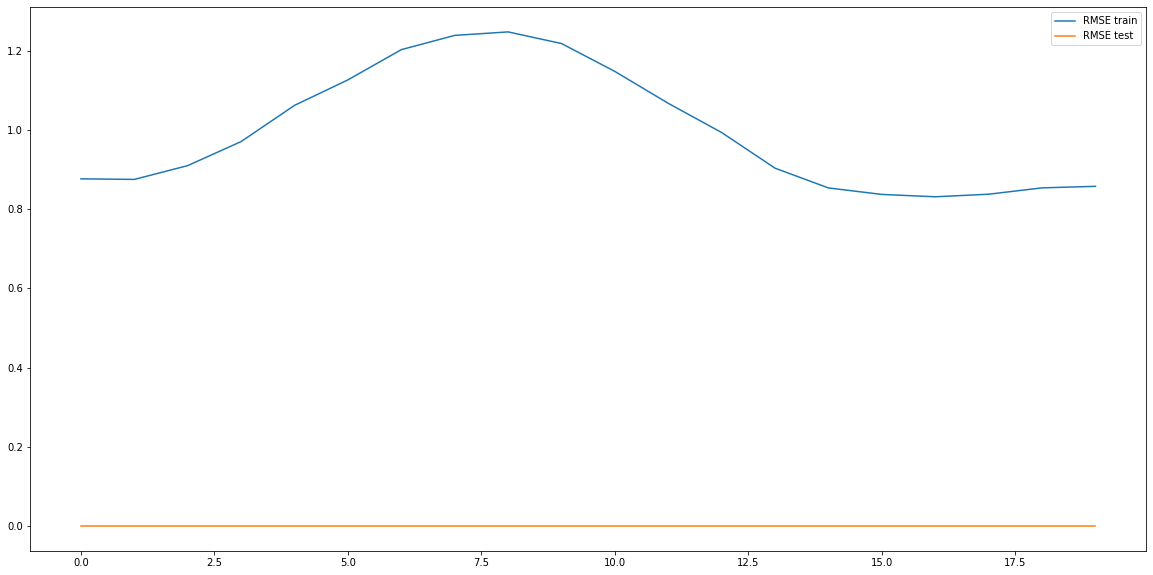

In [76]:
_, ax = plt.subplots(1, 1, figsize=(20, 10))

ax.plot(np.arange(len(mt_model.pmf_model.rmse_train)), mt_model.pmf_model.rmse_train, label='RMSE train')
ax.plot(np.arange(len(mt_model.pmf_model.rmse_test)), mt_model.pmf_model.rmse_test, label='RMSE test')
ax.legend()

plt.show()

In [77]:
%load_ext tensorboard

In [78]:
%tensorboard --logdir logs
# deactive tracking protection of the page if you get 403 error


# test code

In [ ]:
#log_ps, mse_train, mse_test= pm.train(10)

In [ ]:

# dec_result,dec_state=decoder(dec_output_tokens,dec_output_tokens,context_vector= user_context_vector,state=dec_state)
# sampled_token = tf.random.categorical(dec_result[:,-1, :], num_samples=1)
# print( sampled_token.numpy())
# dec_output_tokens=np.append( dec_output_tokens , sampled_token.numpy()[0])
# print(dec_output_tokens)

# vocab = np.array(input_text_processor.get_vocabulary())
# first_word = vocab[dec_output_tokens]
# first_word